In [139]:
import os
import numpy as np
import pandas as pd
from us import states
import matplotlib.pyplot as plt
from scipy import integrate, optimize
from sklearn.linear_model import LinearRegression

# Data

We need daily count and population per state

In [31]:
data = pd.read_csv('data/daily.csv', parse_dates=['date'])[['date', 'state', 'positive', 'negative', 'death', 'deathIncrease', 'positiveIncrease']]

In [32]:
population = pd.read_csv('data/states_pop.csv')
population.index = population.State.apply(lambda s: states.lookup(s).abbr)
population = population['Population']

In [33]:
data

date state  positive  negative  death  deathIncrease  \
0    2020-04-08    AK     226.0    6842.0    7.0            1.0   
1    2020-04-08    AL    2369.0   16753.0   66.0           10.0   
2    2020-04-08    AR    1000.0   13530.0   18.0            2.0   
3    2020-04-08    AS       0.0      20.0    0.0            0.0   
4    2020-04-08    AZ    2726.0   31838.0   80.0            7.0   
...         ...   ...       ...       ...    ...            ...   
1872 2020-03-04    OR       3.0      29.0    NaN            NaN   
1873 2020-03-04    SC       0.0       5.0    NaN            NaN   
1874 2020-03-04    TX       1.0       NaN    NaN            NaN   
1875 2020-03-04    WA      39.0       NaN   10.0            NaN   
1876 2020-03-04    WI       1.0      19.0    NaN            NaN   

      positiveIncrease  
0                 13.0  
1                250.0  
2                 54.0  
3                  0.0  
4                151.0  
...                ...  
1872               NaN  
1873               NaN  
1874               NaN  
1875               NaN  
1876               NaN  

[1877 rows x 7 columns]

# Models

Build two simple models: a exponential regression and a sir model

In [49]:
def regression(train, test):
    """
        Regression of positive and death
    """
    lr = LinearRegression()
    
    # Positive
    try:
        positive_train = train.loc[train.positive > 0]
        lr.fit(np.array(positive_train.Time).reshape(-1, 1), np.log(positive_train.positive.values + 1))
        positive = np.exp(lr.predict(test.Time.values.reshape(-1, 1))) - 1
        positive[positive < 0] = 0
    except:
        positive = [0] * len(data)
        
    # Death
    try:
        death_train = train.loc[train.death > 0]
        lr.fit(np.array(death_train.Time).reshape(-1, 1), np.log(death_train.death.values + 1))
        deaths = np.exp(lr.predict(test.Time.values.reshape(-1, 1))) - 1
        deaths[deaths < 0] = 0
    except:
        deaths = [0] * len(data)
    
    return pd.DataFrame({'pred_case': positive,'pred_death': deaths}, index = test.date)

In [134]:
def sir(train, test):
    """
        Regression of positive and death
        
        Inspired by https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions
    """
    try:
        # Points of interests
        positive_train = train.loc[train.positive > 0]
        
        # Initial params
        pop = float(population[train.state.iloc[0]])
        r0 = 0
        i0 = positive_train.positive.iloc[0]
        s0 = pop - i0
        
        observed_death = positive_train.death.sum() / positive_train.positive.sum()

        def sir_model(y, x, beta, gamma):
            pred_s, pred_i, pred_r = y
            s = - beta * pred_s * pred_i / pop
            r = gamma * pred_i
            i = - (s + r)
            return s, i, r

        def fit_I(x, beta, gamma):
            return integrate.odeint(sir_model, (s0, i0, r0), x, args=(beta, gamma))[:, 1]
        
        def fit_SIR(x, beta, gamma):
            return integrate.odeint(sir_model, (s0, i0, r0), x, args=(beta, gamma))

        params, _ = optimize.curve_fit(fit_I, positive_train.Time.values, positive_train.positiveIncrease.values)
        positive = fit_SIR(test[test.index >= positive_train.index[0]].Time.values, *params)
        positive, deaths = positive[:, 1], positive[:, 2] * observed_death
        
        # Add 0 at the start
        positive = np.concatenate([[0] * len(test.loc[test.index < positive_train.index[0]]), np.cumsum(positive)])
        deaths = np.concatenate([[0] * len(test.loc[test.index < positive_train.index[0]]), np.cumsum(deaths)])
    except Exception as e:
        positive = np.array([0] * len(test))
        deaths = np.array([0] * len(test))
    
    return pd.DataFrame({'pred_case': positive,'pred_death': deaths}, index = test.date)

# Experiments

Train on all datapoints prior to the given date and test on all.
Save as STATE_DATE.csv the date indicates until when the train set stops

In [ ]:
date_predictions = [pd.to_datetime(d) for d in ['20200328', '20200329', '20200330', '20200331', '20200401', '20200402', '20200403']]

Prediction 2020-03-28 00:00:00
	AK


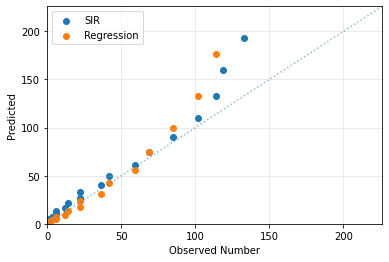

	AL


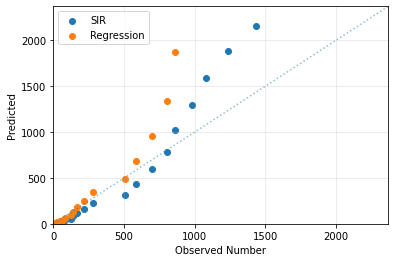

	AR


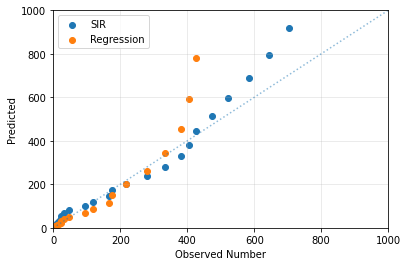

	AS


/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


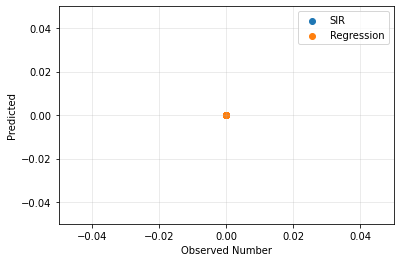

	AZ


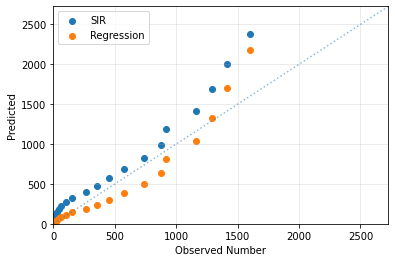

	CA


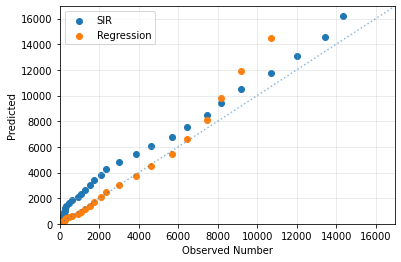

	CO


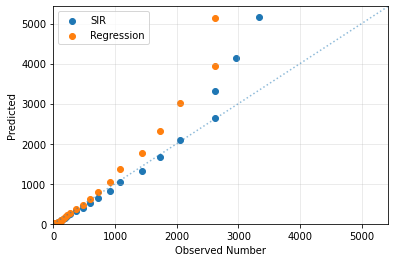

	CT


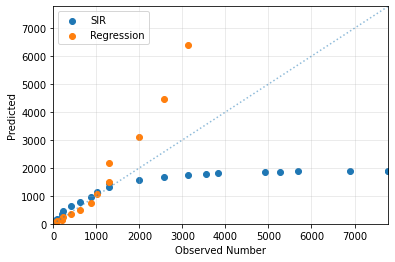

	DC


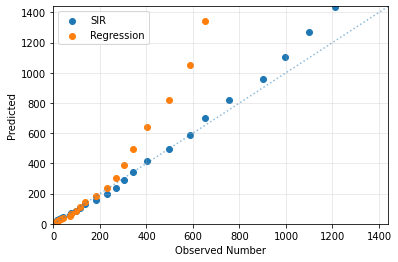

	DE


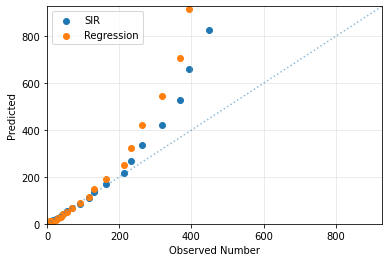

	FL


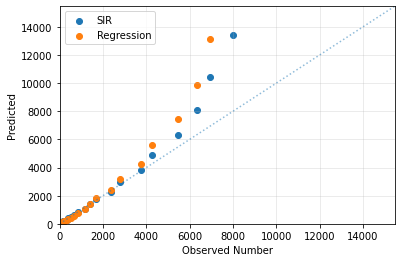

	GA


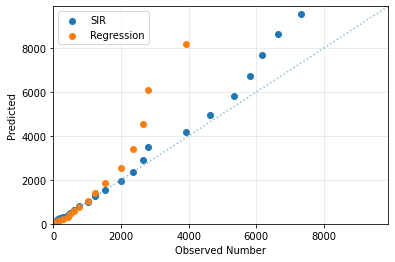

	GU


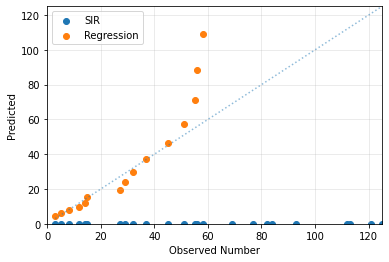

	HI


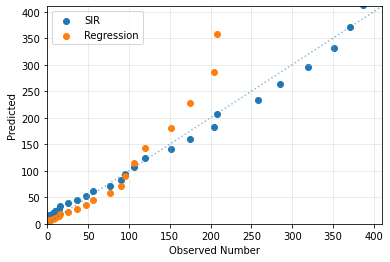

	IA


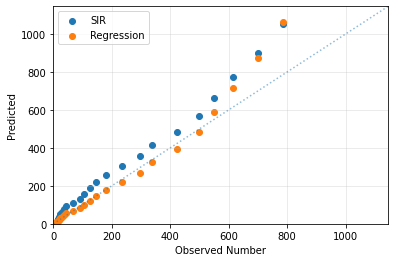

	ID


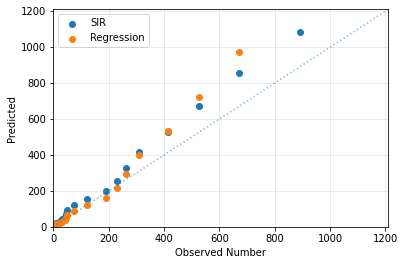

	IL


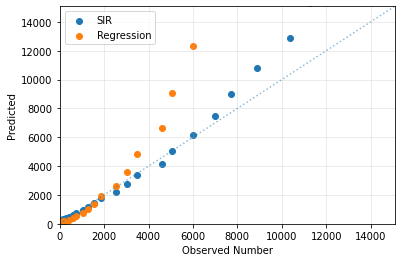

	IN


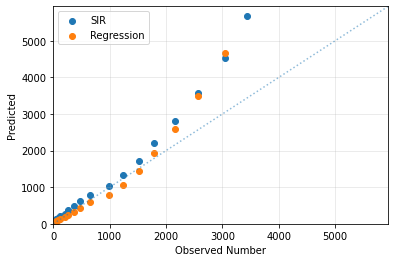

	KS


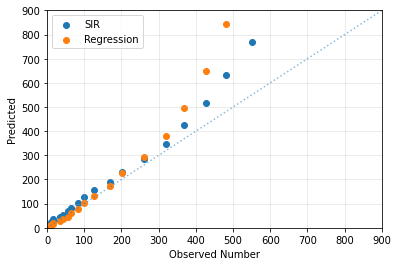

	KY


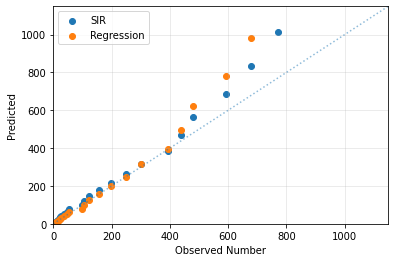

	LA


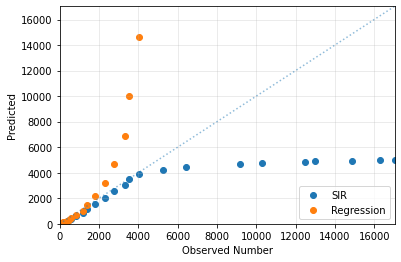

	MA


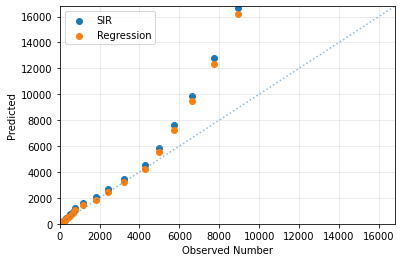

	MD


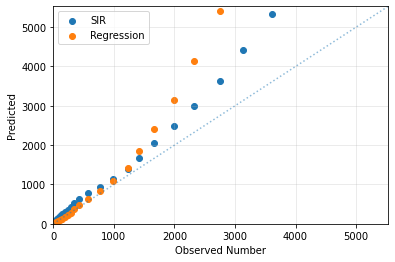

	ME


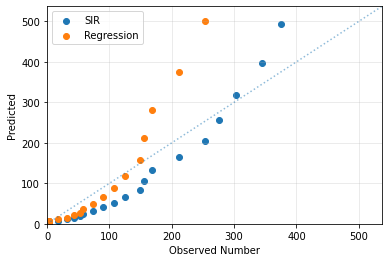

	MI


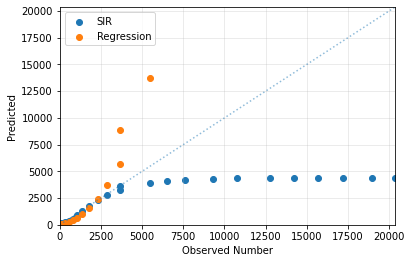

	MN


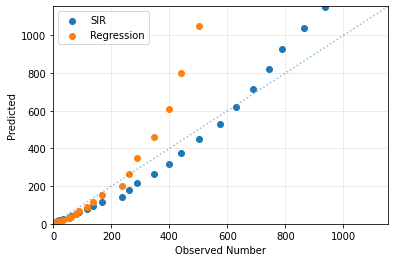

	MO


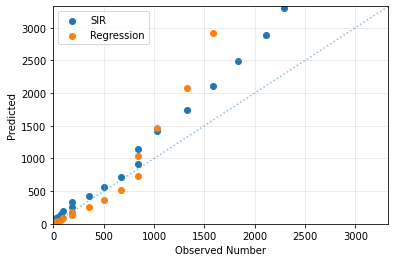

	MP


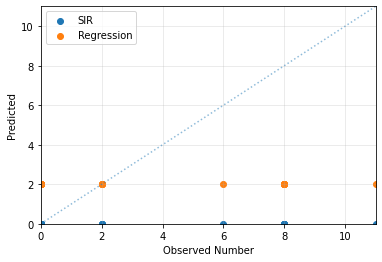

	MS


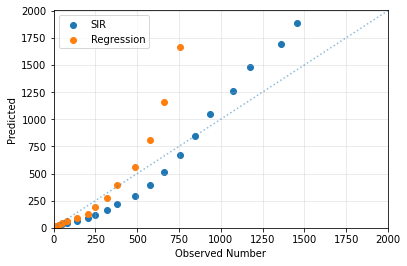

	MT


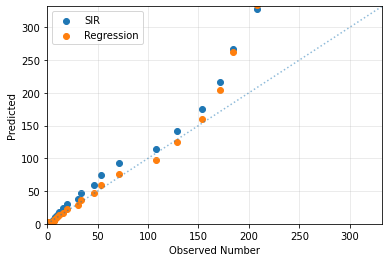

	NC


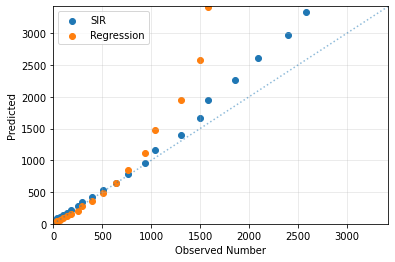

	ND


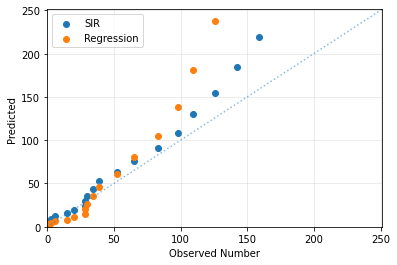

	NE


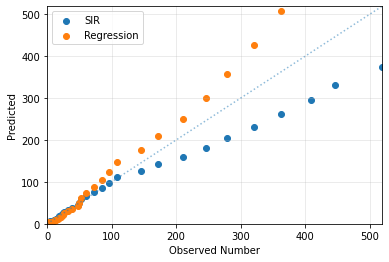

	NH


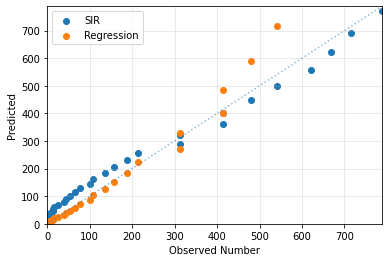

	NJ


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


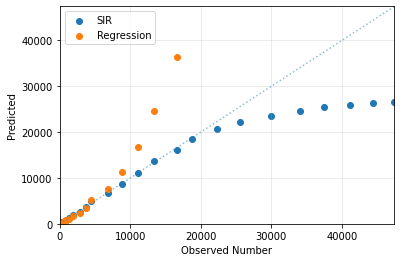

	NM


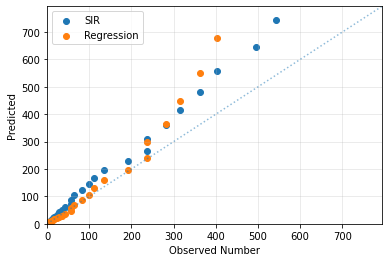

	NV


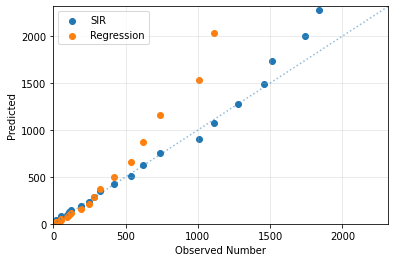

	NY


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


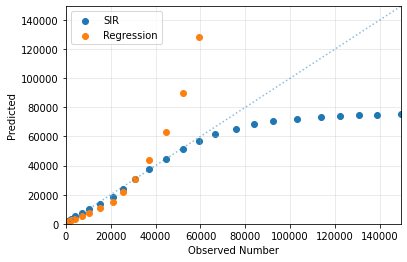

	OH


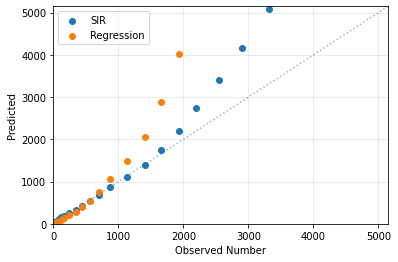

	OK


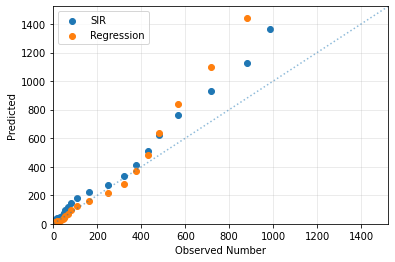

	OR


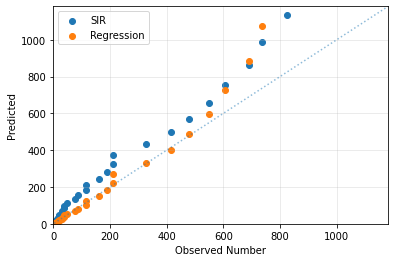

	PA


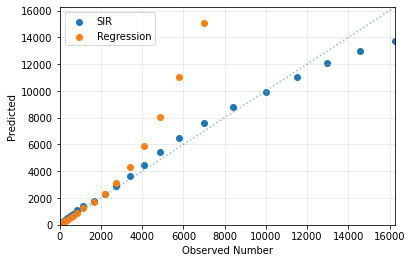

	PR


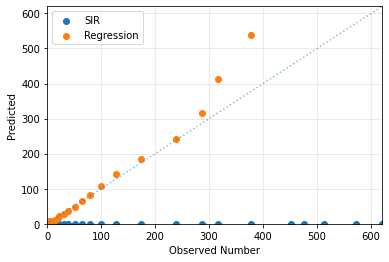

	RI


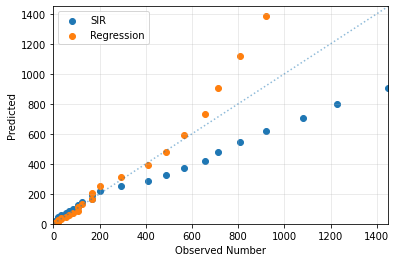

	SC


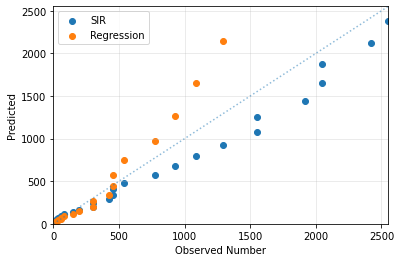

	SD


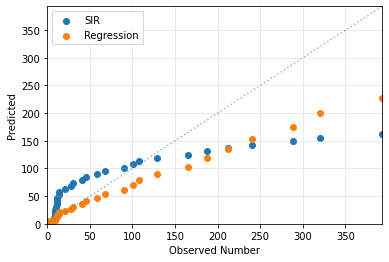

	TN


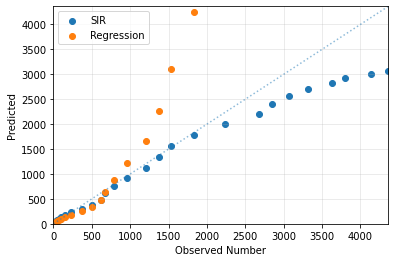

	TX


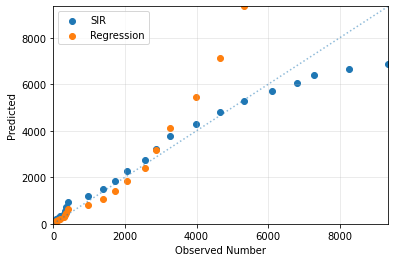

	UT


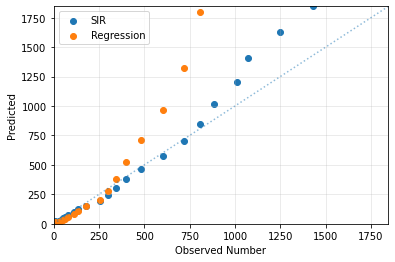

	VA


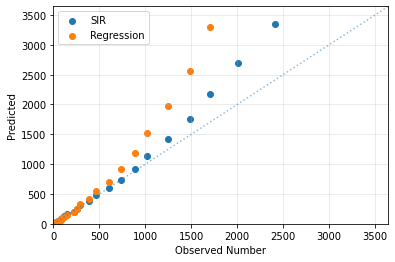

	VI


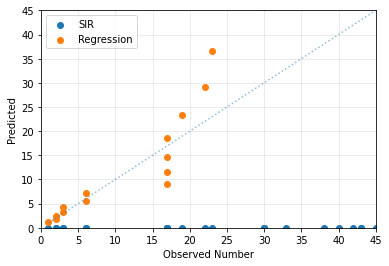

	VT


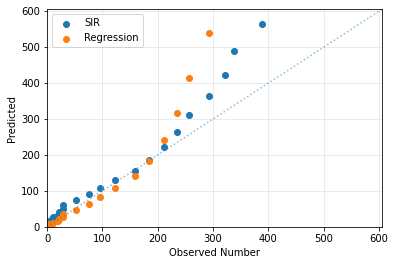

	WA


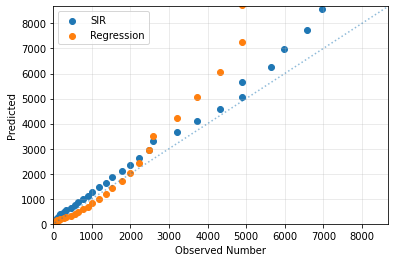

	WI


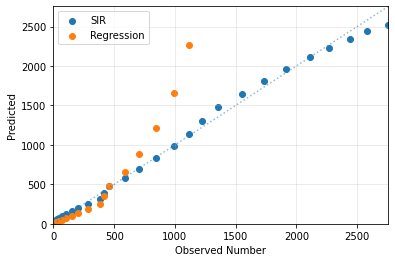

	WV


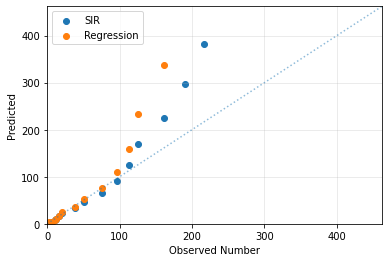

	WY


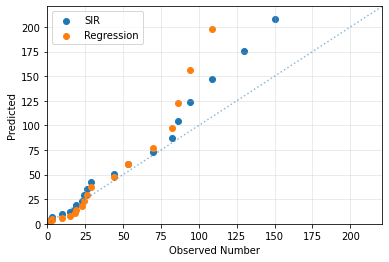

Prediction 2020-03-29 00:00:00
	AK


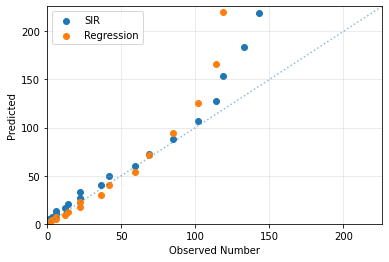

	AL


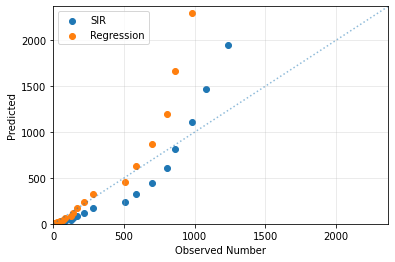

	AR


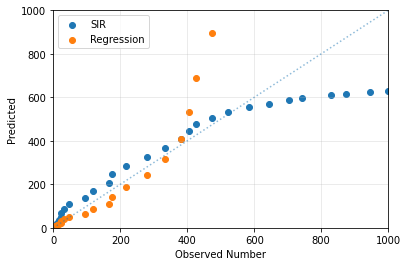

	AS


/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


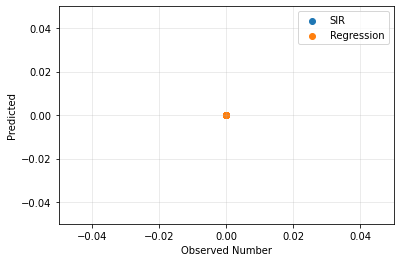

	AZ


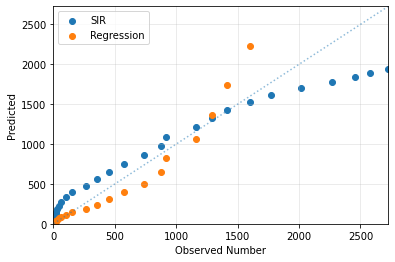

	CA


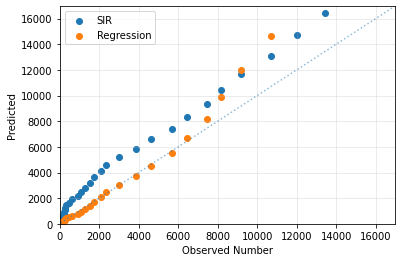

	CO


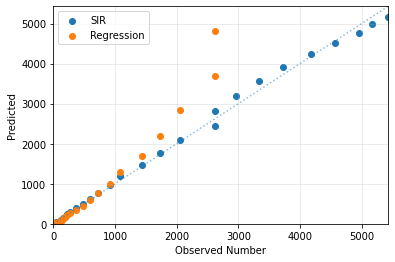

	CT


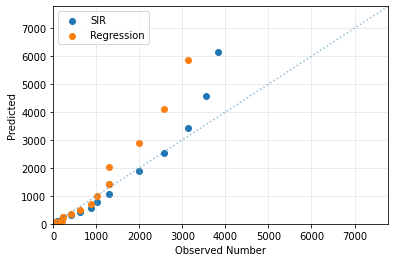

	DC


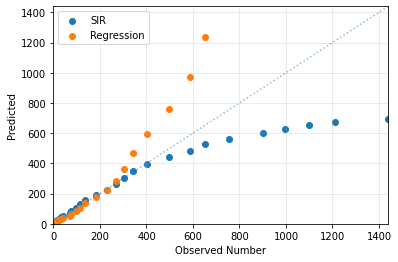

	DE


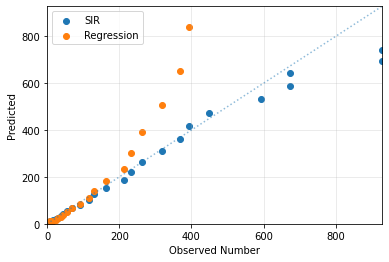

	FL


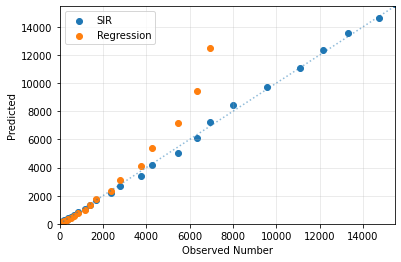

	GA


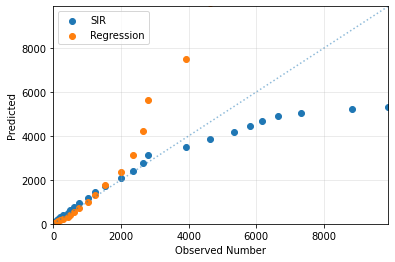

	GU


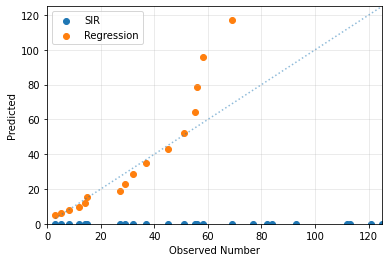

	HI


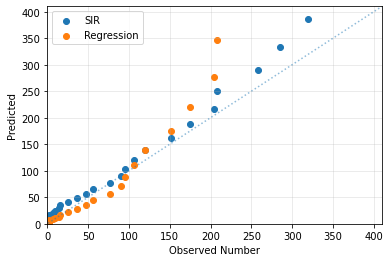

	IA


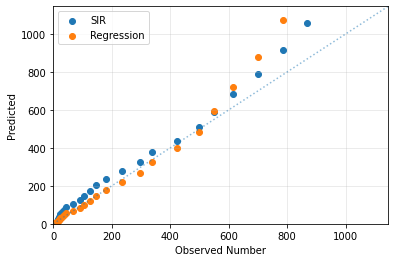

	ID


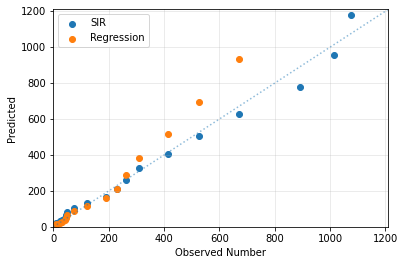

	IL


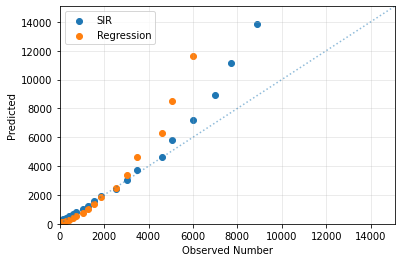

	IN


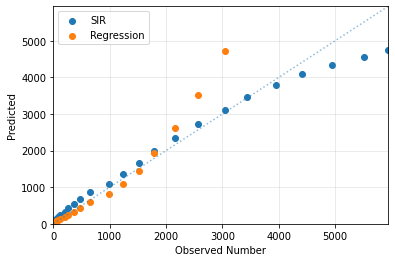

	KS


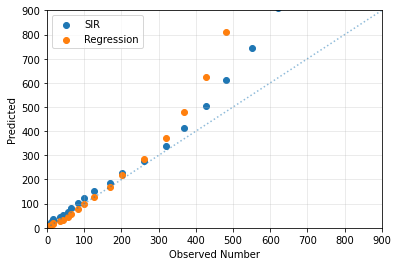

	KY


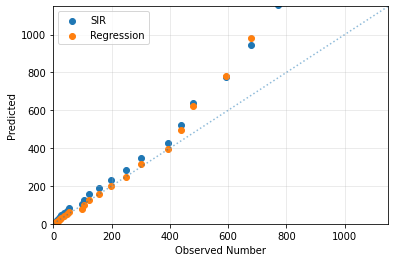

	LA


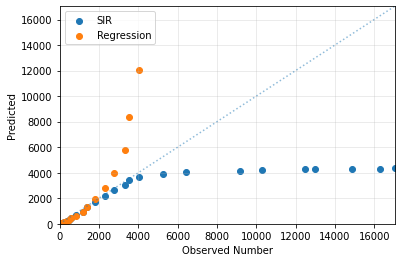

	MA


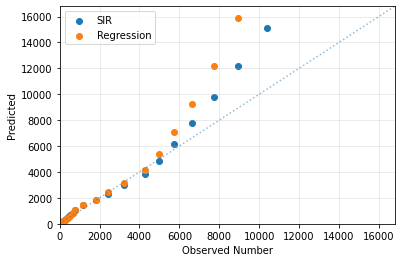

	MD


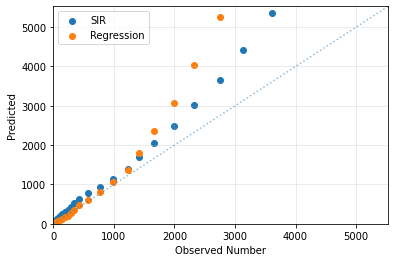

	ME


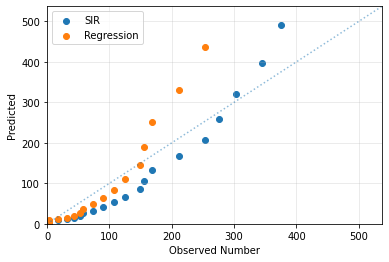

	MI


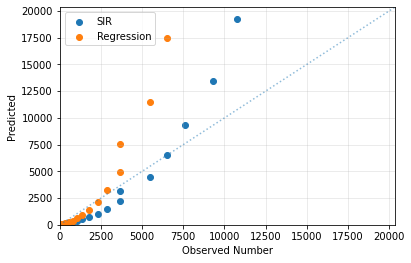

	MN


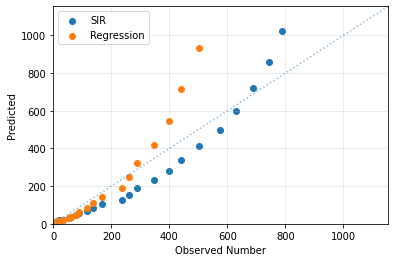

	MO


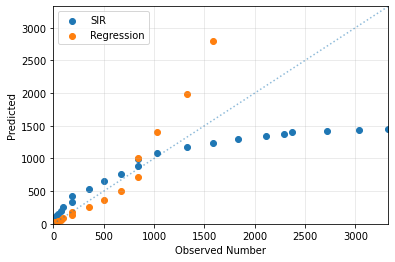

	MP


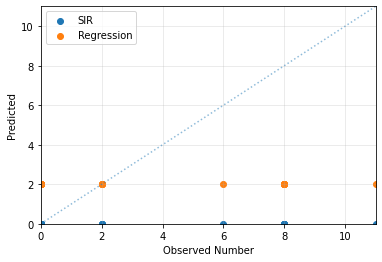

	MS


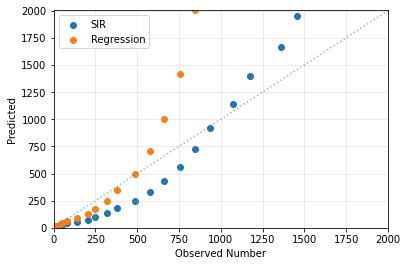

	MT


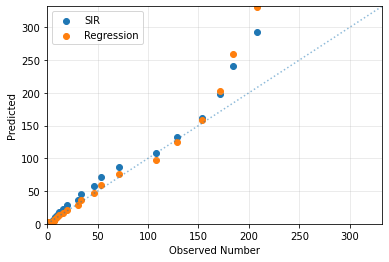

	NC


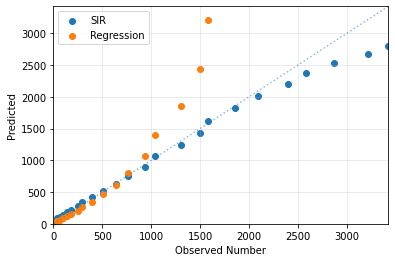

	ND


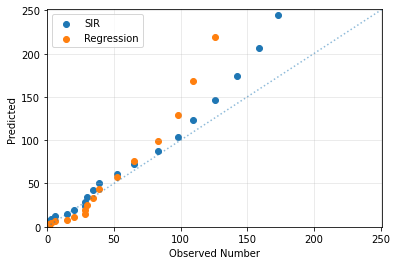

	NE


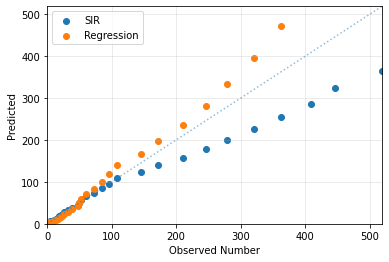

	NH


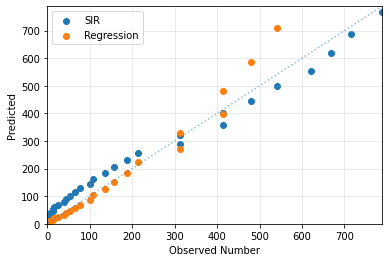

	NJ


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


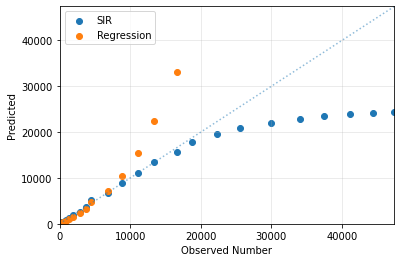

	NM


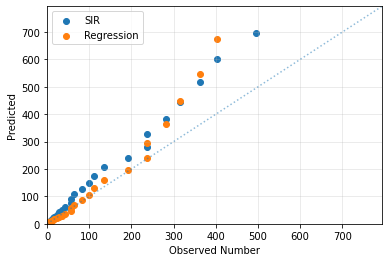

	NV


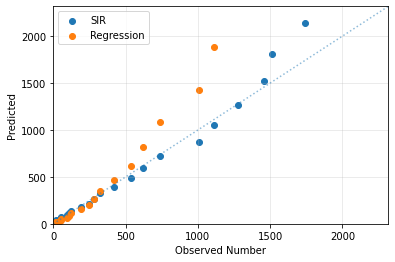

	NY


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


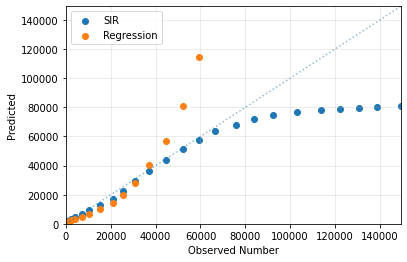

	OH


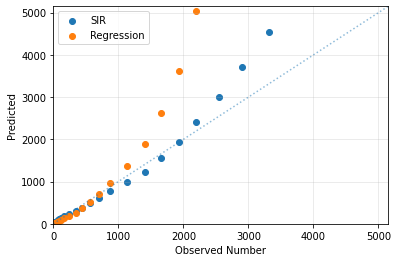

	OK


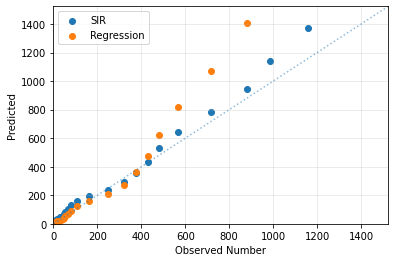

	OR


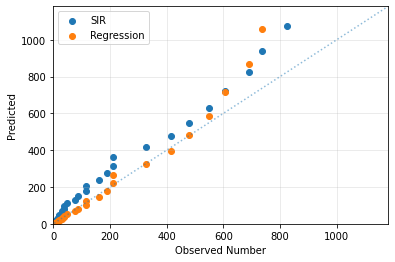

	PA


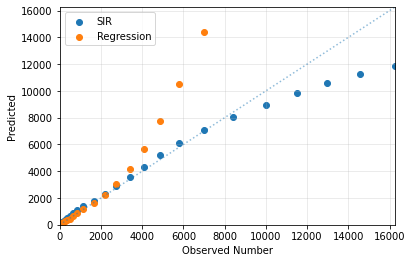

	PR


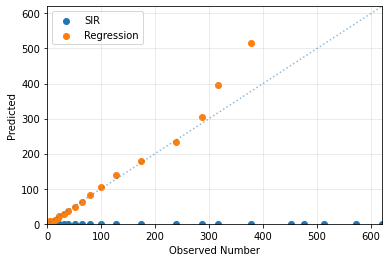

	RI


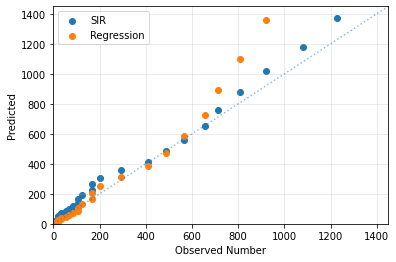

	SC


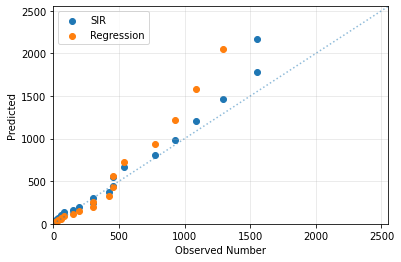

	SD


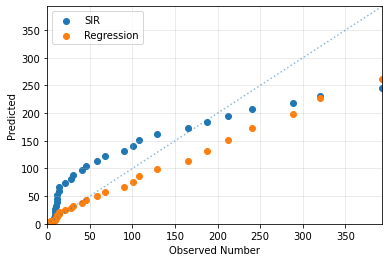

	TN


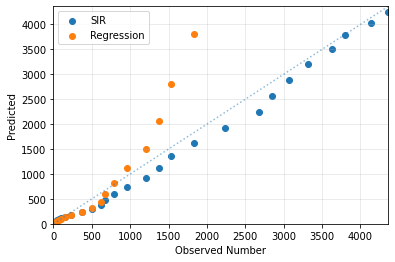

	TX


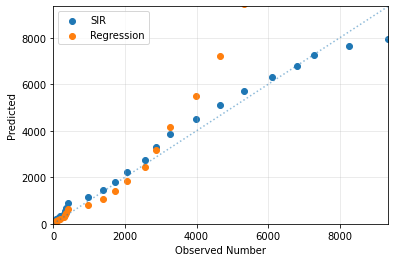

	UT


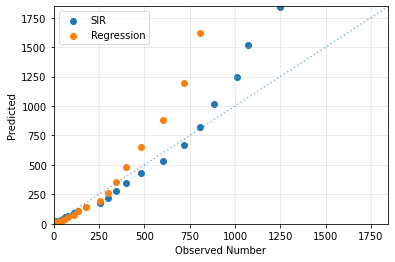

	VA


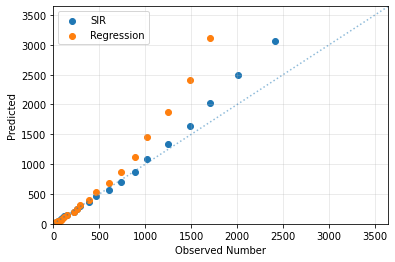

	VI


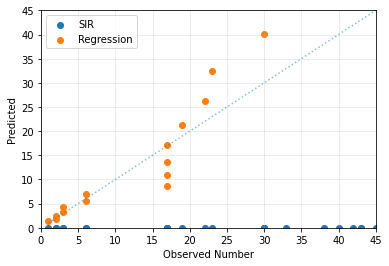

	VT


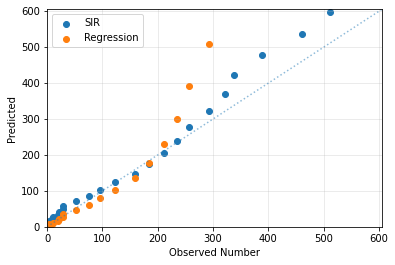

	WA


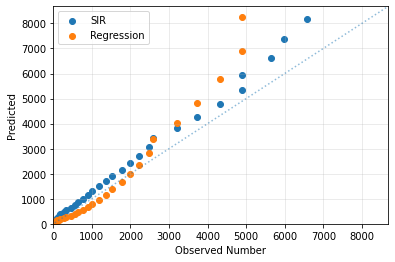

	WI


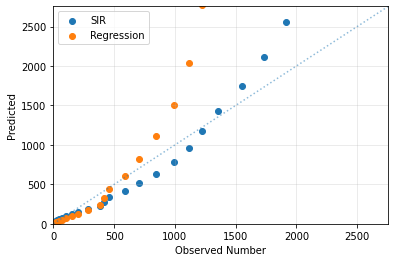

	WV


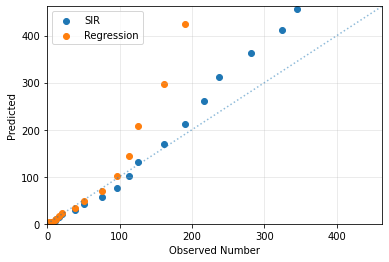

	WY


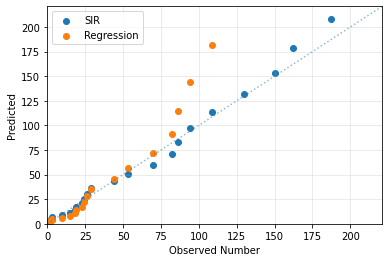

Prediction 2020-03-30 00:00:00
	AK


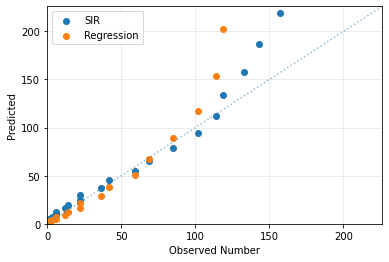

	AL


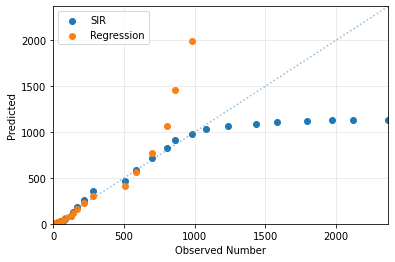

	AR


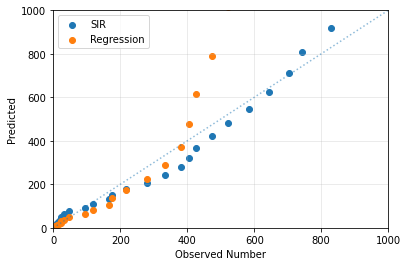

	AS


/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


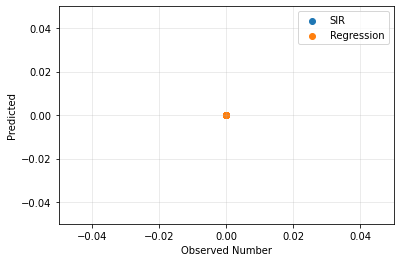

	AZ


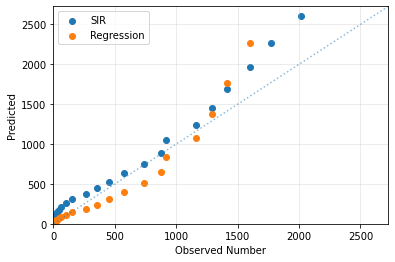

	CA


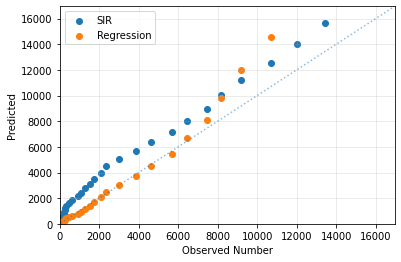

	CO


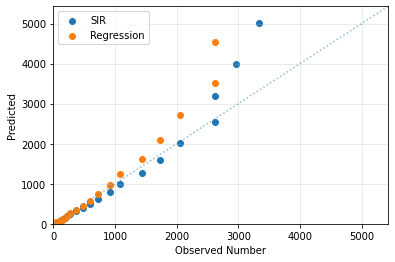

	CT


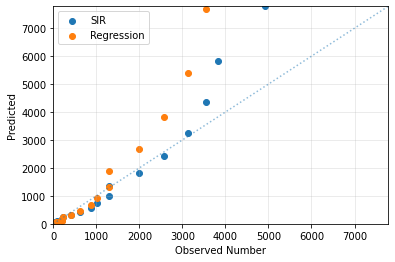

	DC


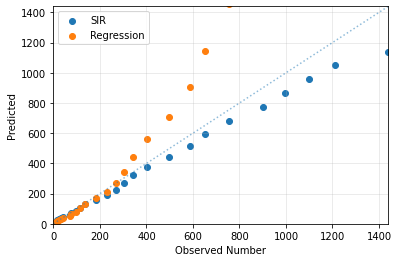

	DE


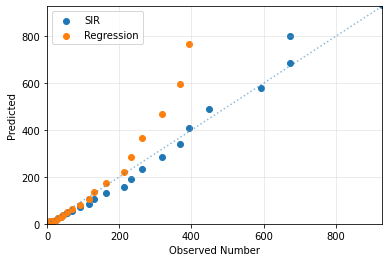

	FL


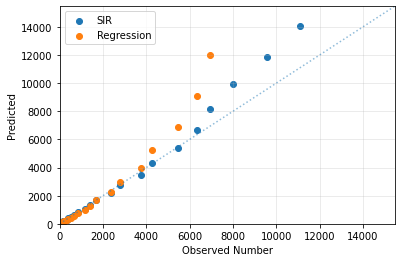

	GA


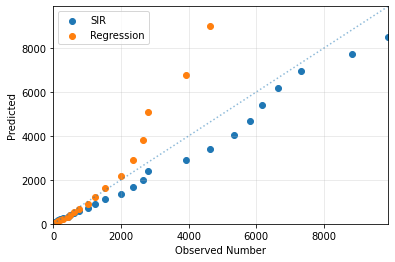

	GU


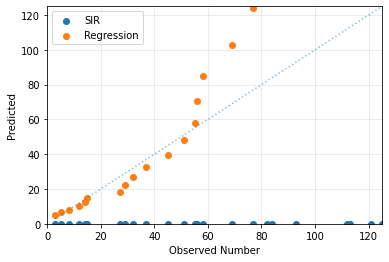

	HI


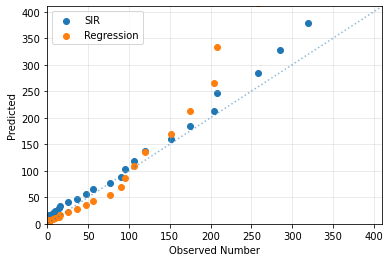

	IA


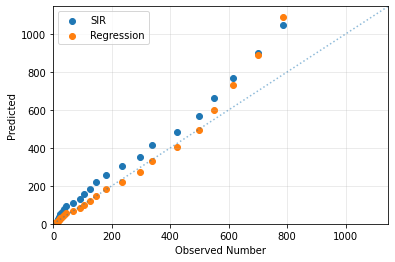

	ID


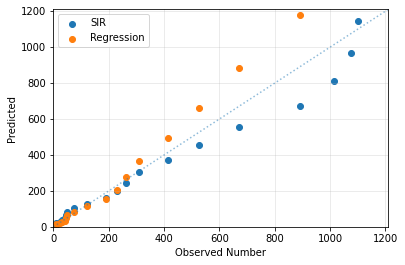

	IL


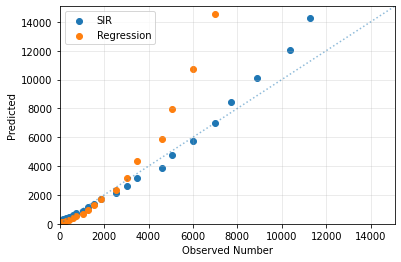

	IN


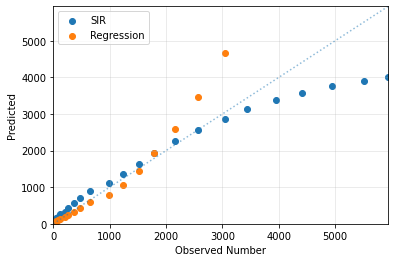

	KS


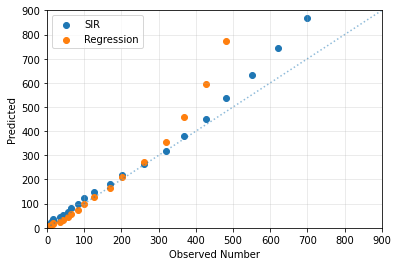

	KY


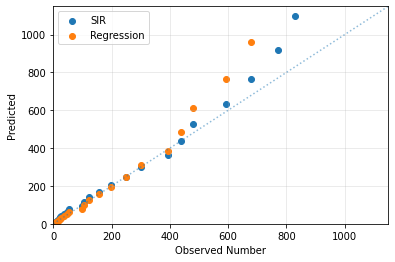

	LA


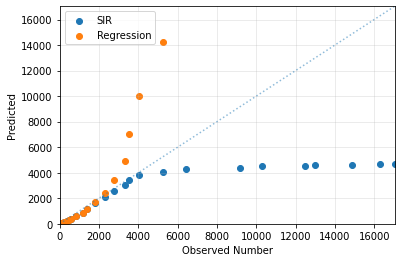

	MA


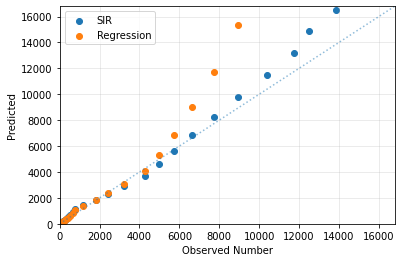

	MD


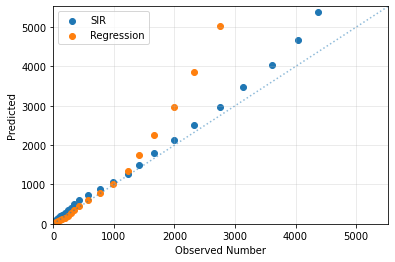

	ME


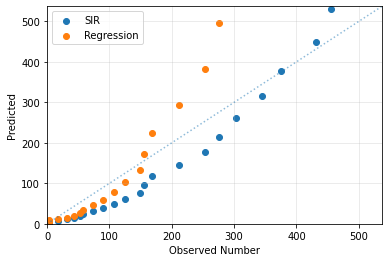

	MI


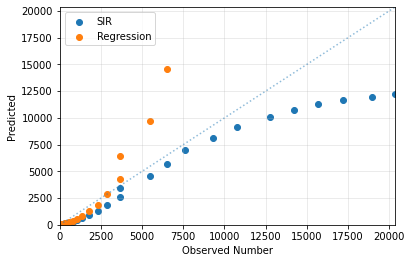

	MN


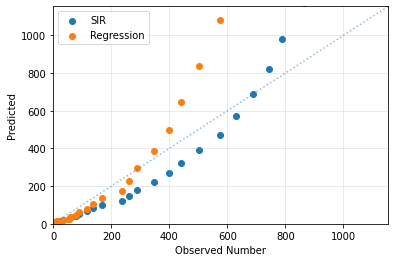

	MO


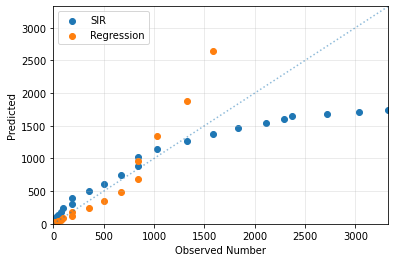

	MP


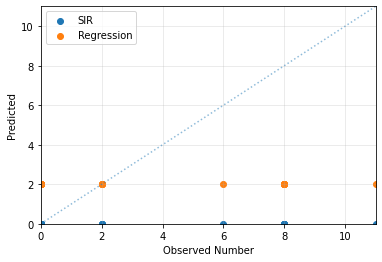

	MS


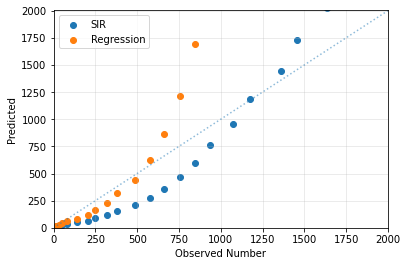

	MT


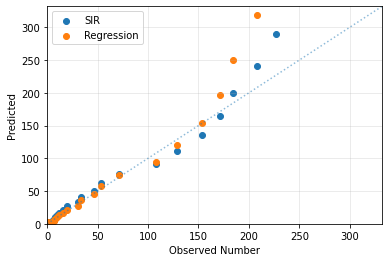

	NC


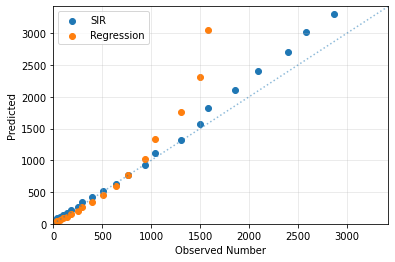

	ND


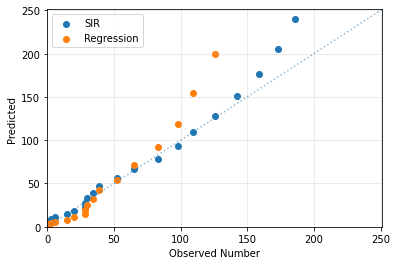

	NE


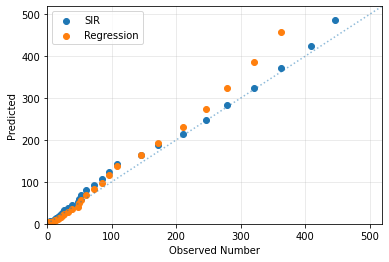

	NH


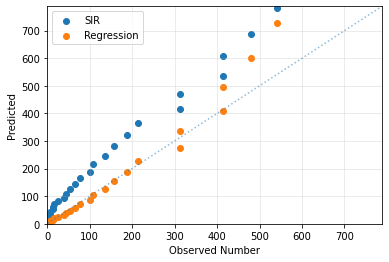

	NJ


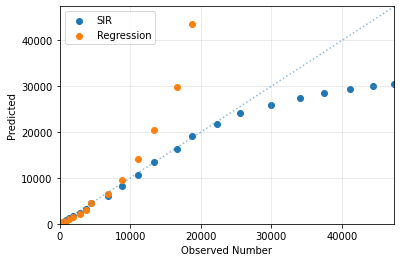

	NM


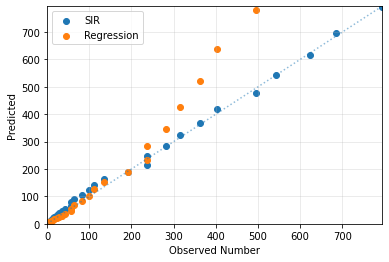

	NV


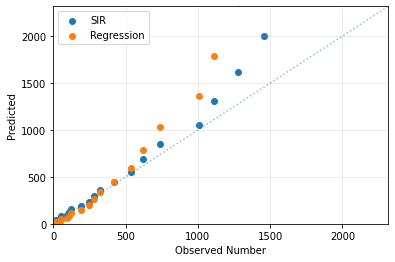

	NY


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


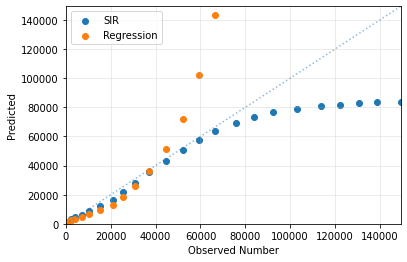

	OH


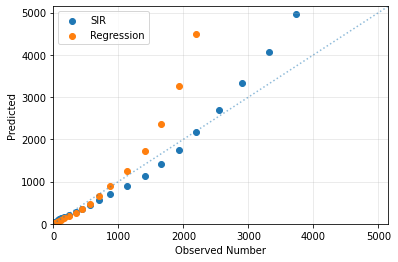

	OK


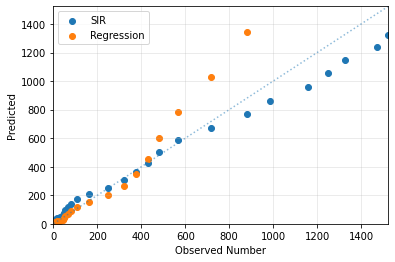

	OR


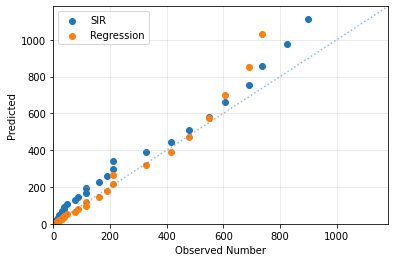

	PA


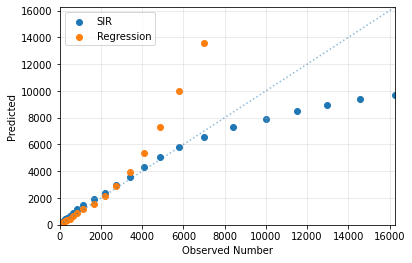

	PR


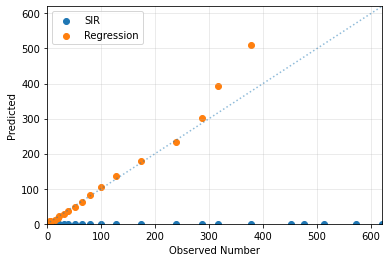

	RI


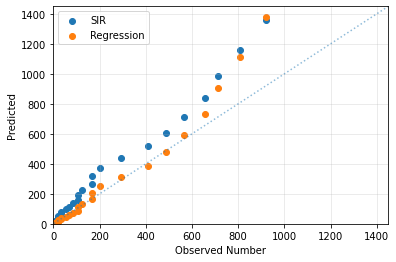

	SC


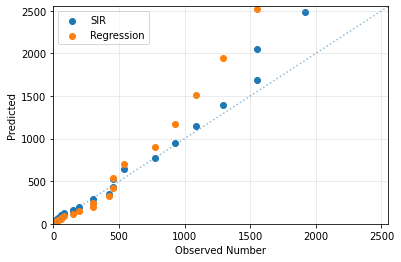

	SD


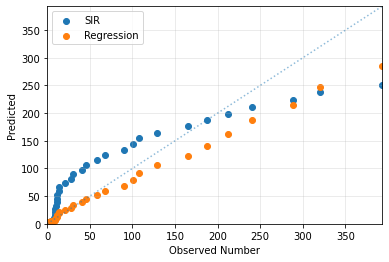

	TN


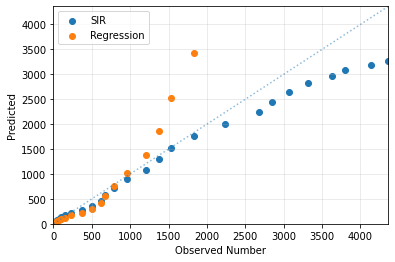

	TX


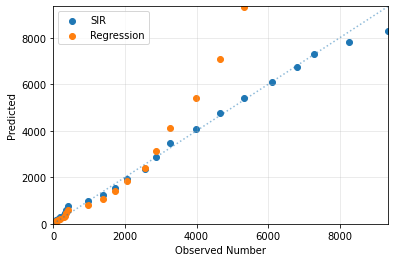

	UT


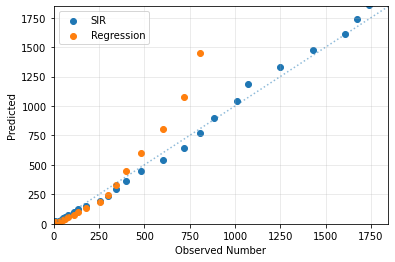

	VA


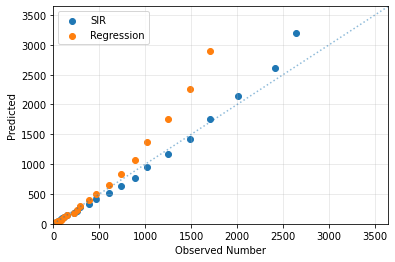

	VI


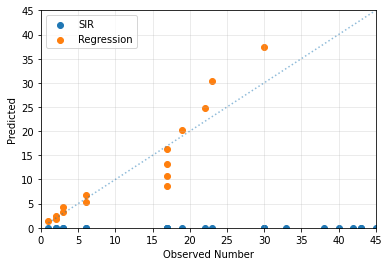

	VT


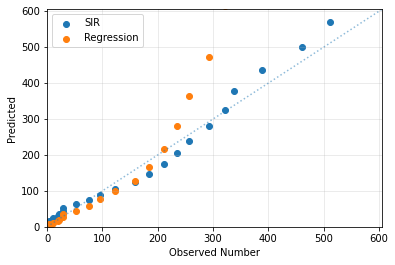

	WA


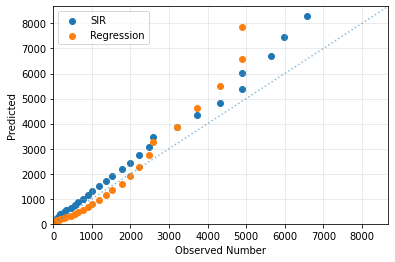

	WI


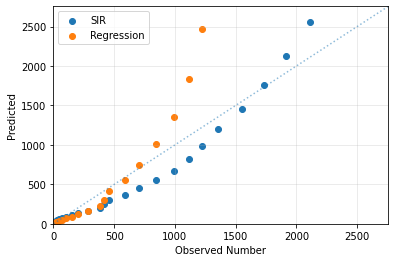

	WV


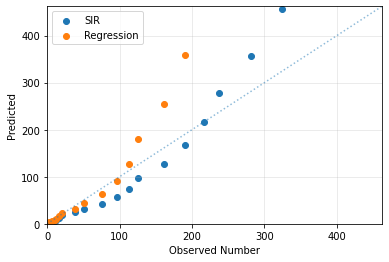

	WY


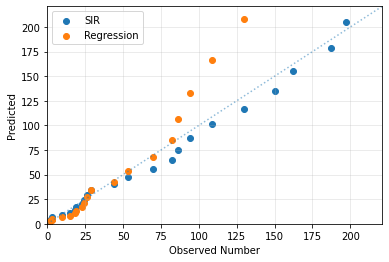

Prediction 2020-03-31 00:00:00
	AK


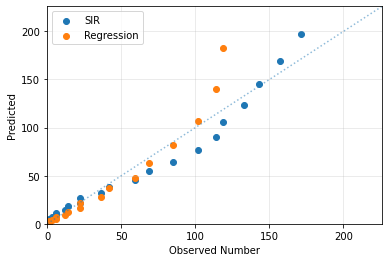

	AL


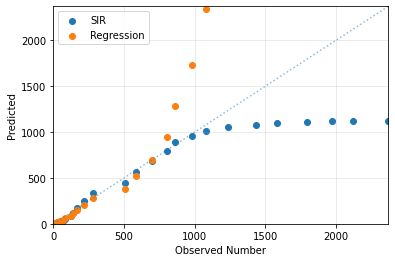

	AR


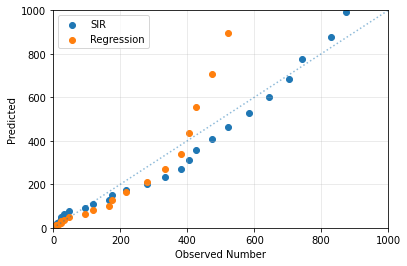

	AS


/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


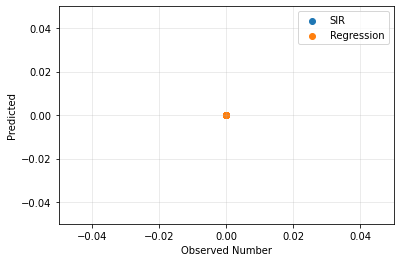

	AZ


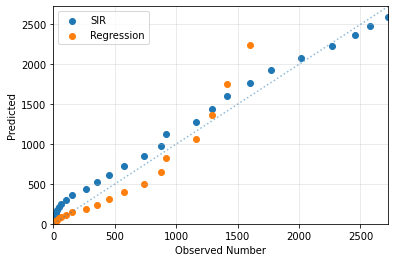

	CA


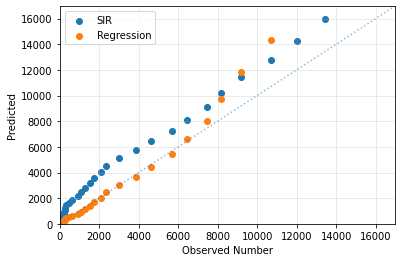

	CO


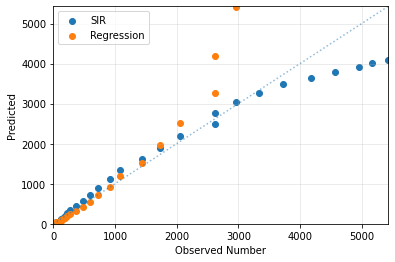

	CT


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


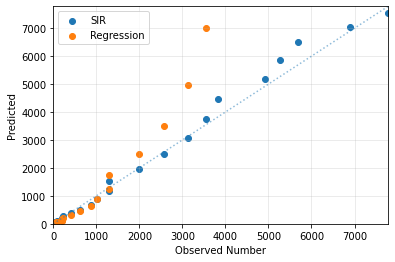

	DC


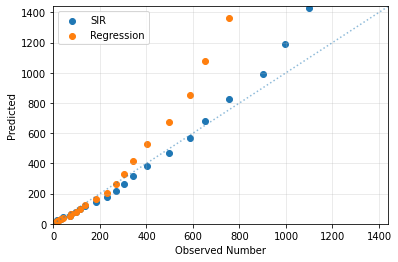

	DE


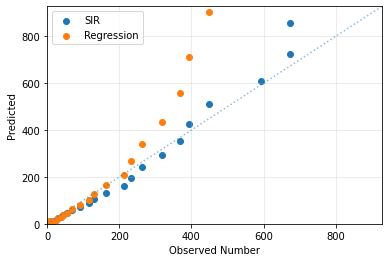

	FL


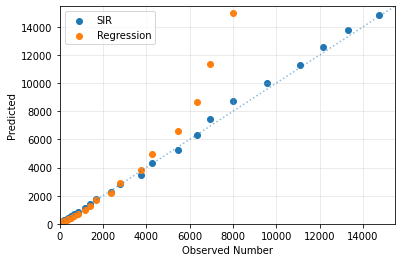

	GA


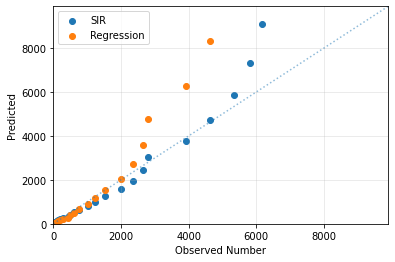

	GU


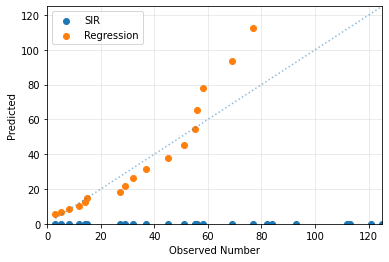

	HI


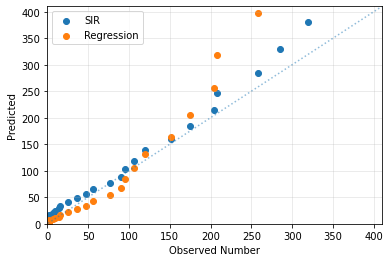

	IA


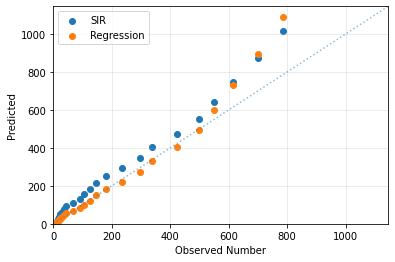

	ID


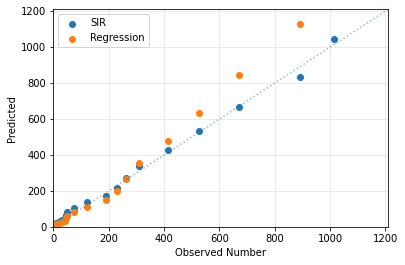

	IL


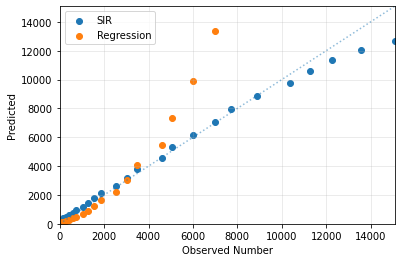

	IN


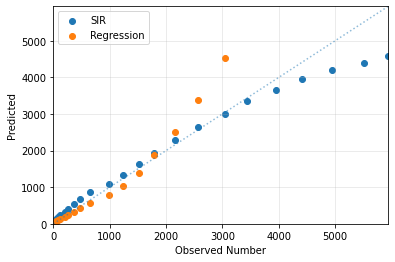

	KS


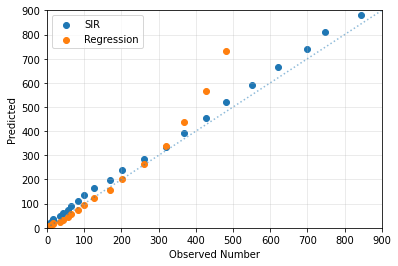

	KY


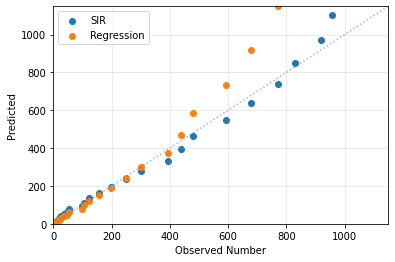

	LA


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


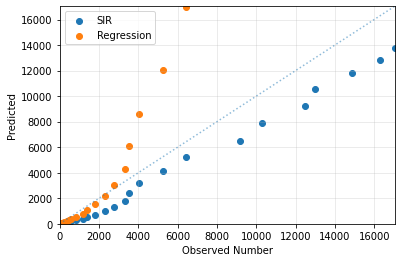

	MA


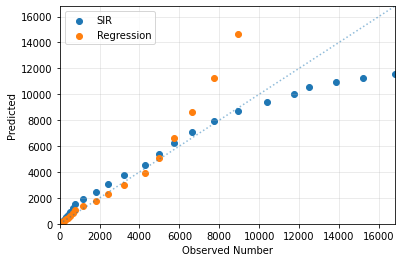

	MD


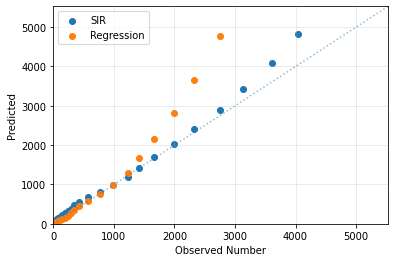

	ME


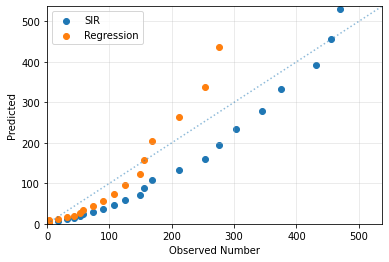

	MI


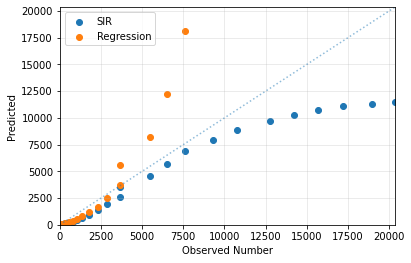

	MN


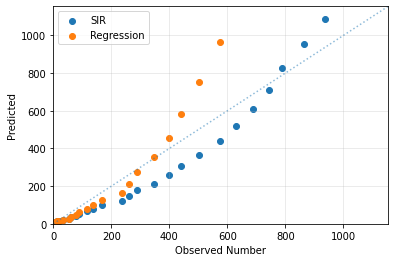

	MO


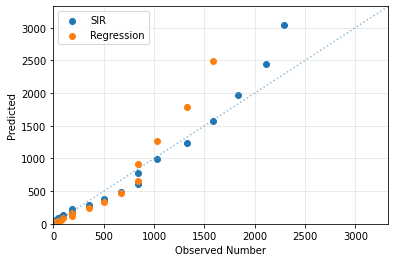

	MP


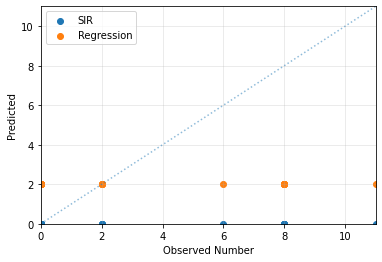

	MS


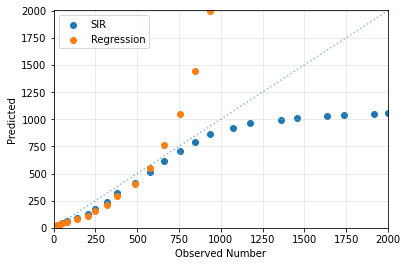

	MT


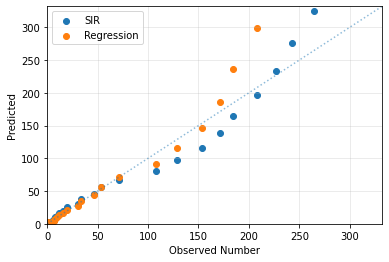

	NC


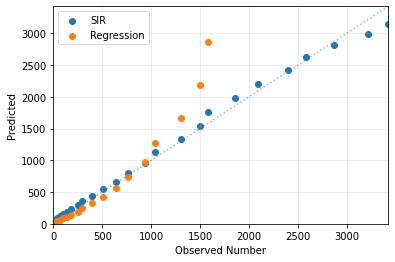

	ND


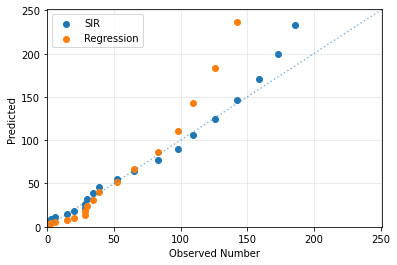

	NE


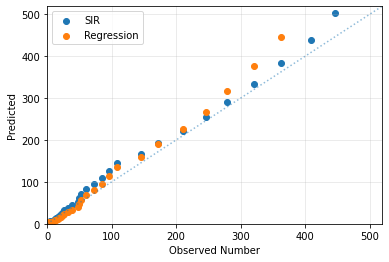

	NH


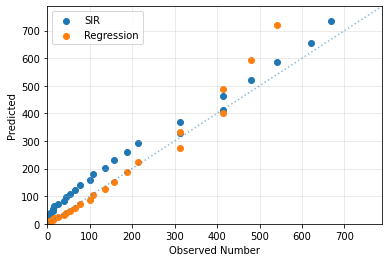

	NJ


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


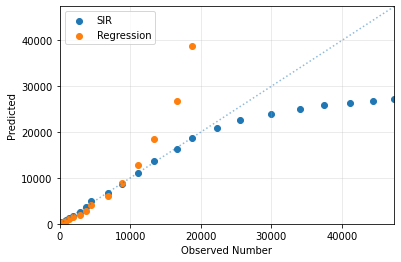

	NM


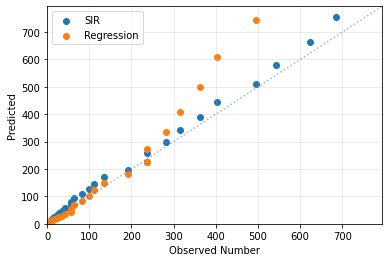

	NV


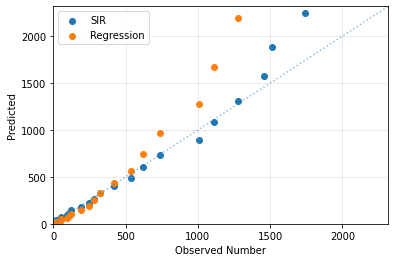

	NY


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


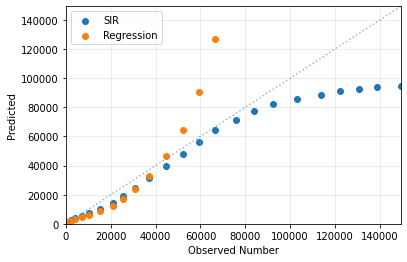

	OH


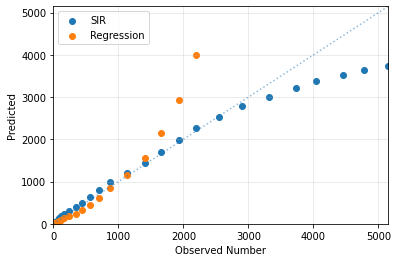

	OK


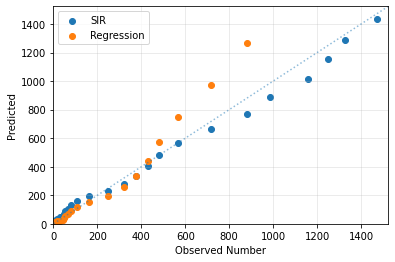

	OR


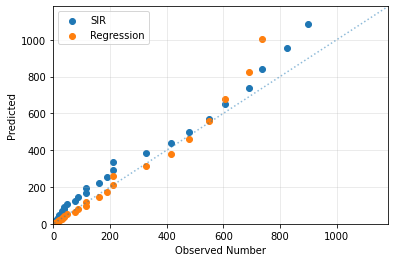

	PA


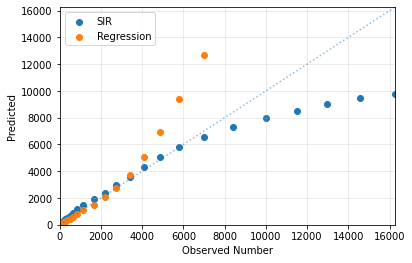

	PR


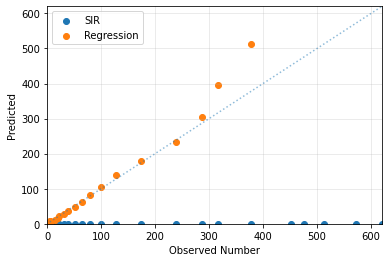

	RI


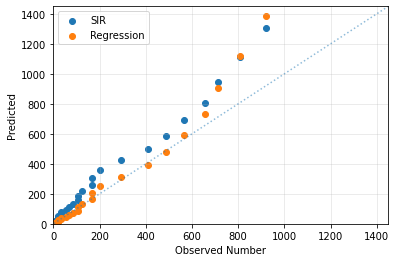

	SC


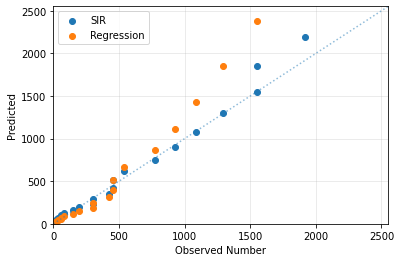

	SD


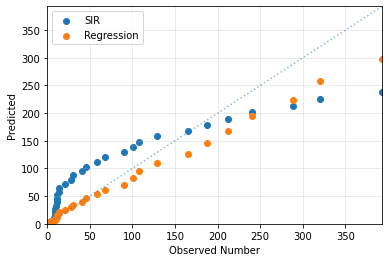

	TN


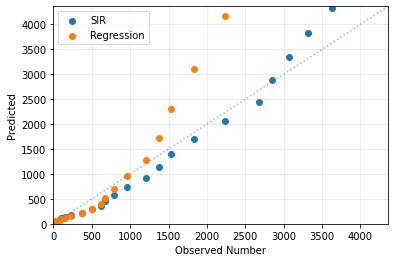

	TX


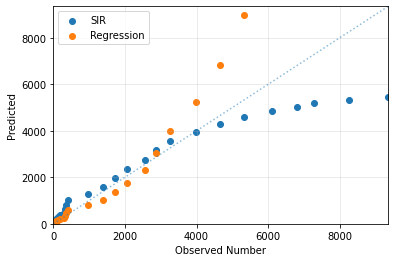

	UT


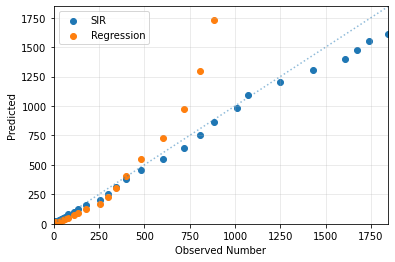

	VA


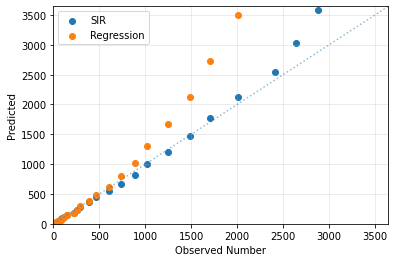

	VI


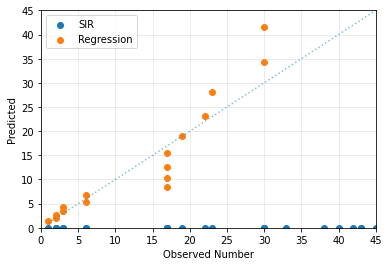

	VT


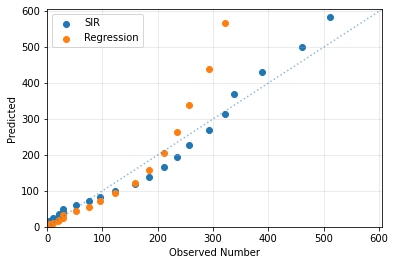

	WA


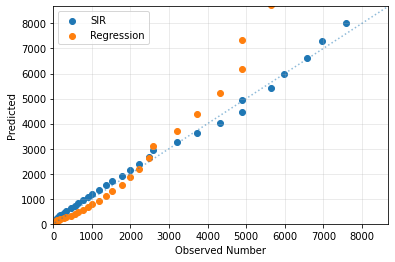

	WI


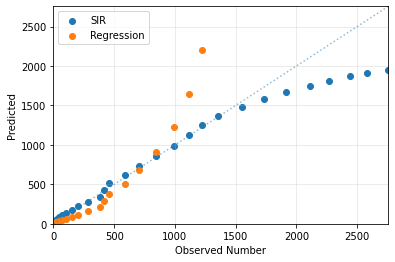

	WV


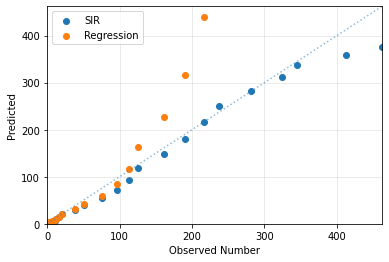

	WY


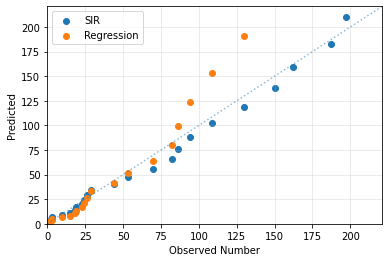

Prediction 2020-04-01 00:00:00
	AK


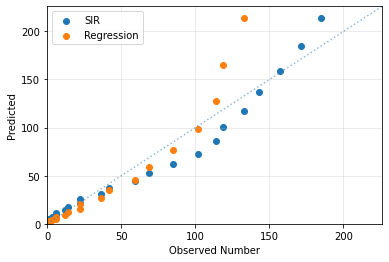

	AL


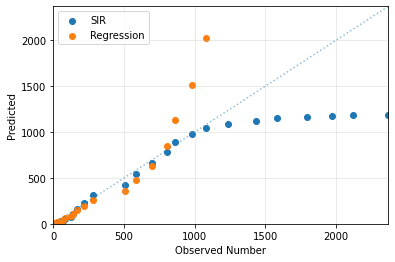

	AR


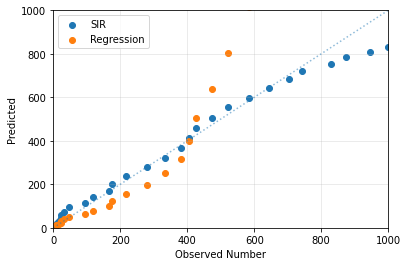

	AS


/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


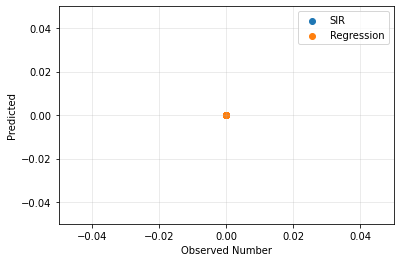

	AZ


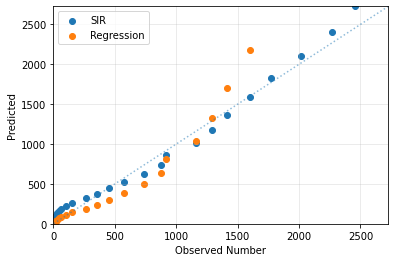

	CA


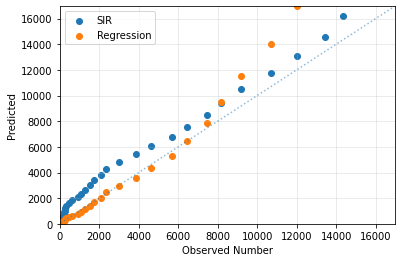

	CO


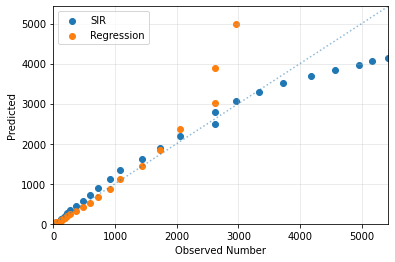

	CT


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


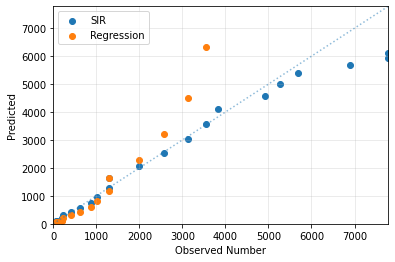

	DC


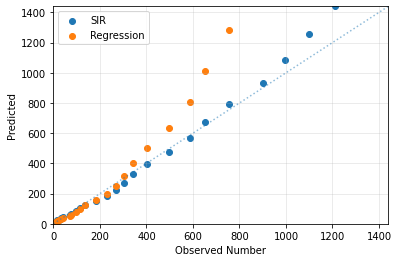

	DE


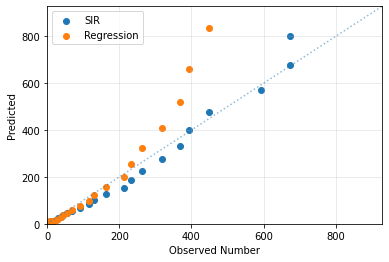

	FL


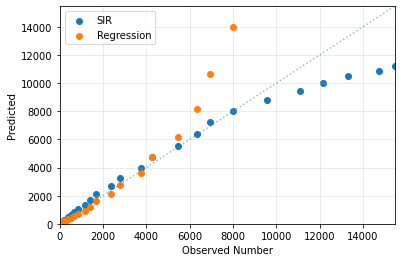

	GA


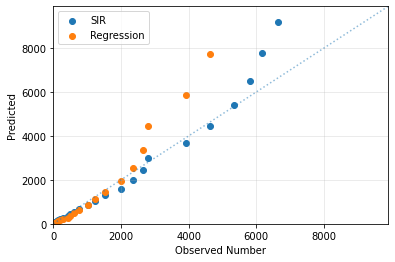

	GU


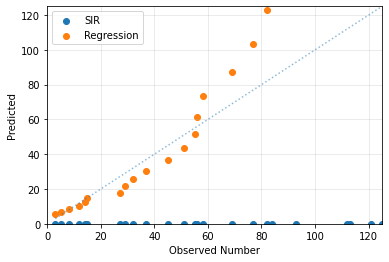

	HI


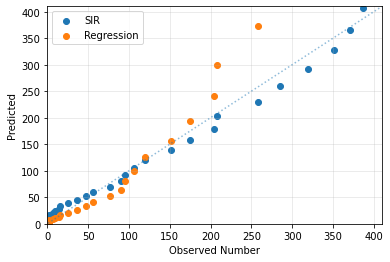

	IA


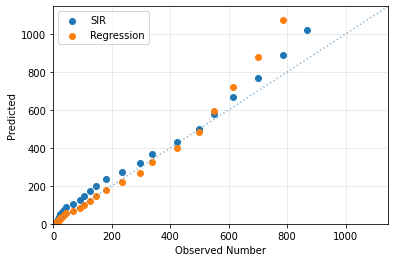

	ID


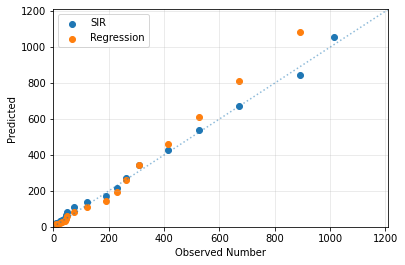

	IL


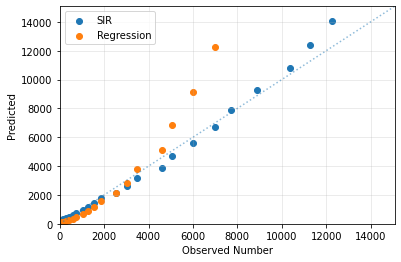

	IN


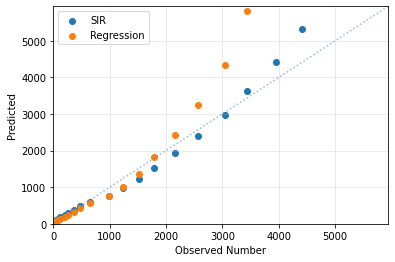

	KS


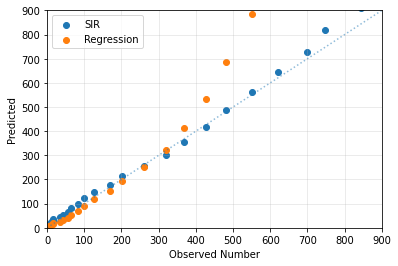

	KY


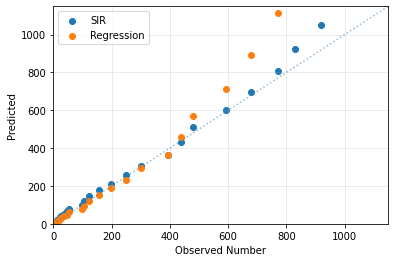

	LA


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


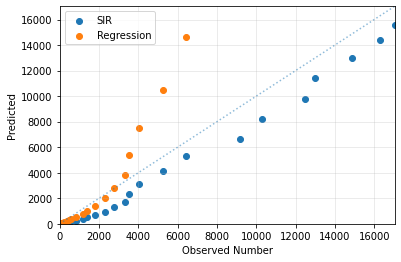

	MA


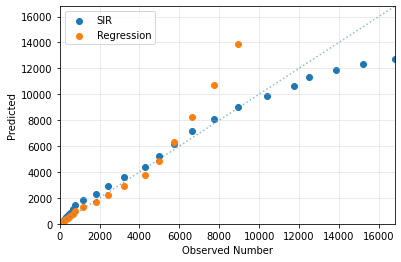

	MD


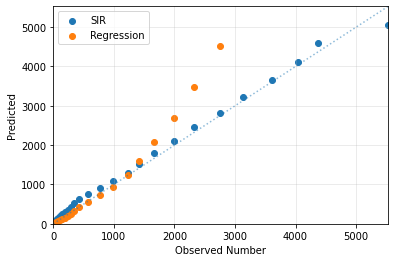

	ME


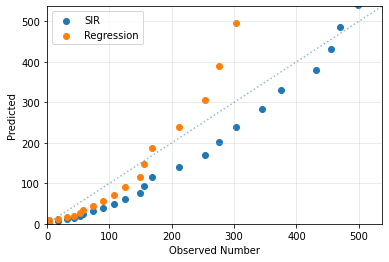

	MI


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


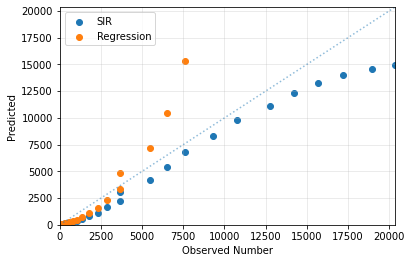

	MN


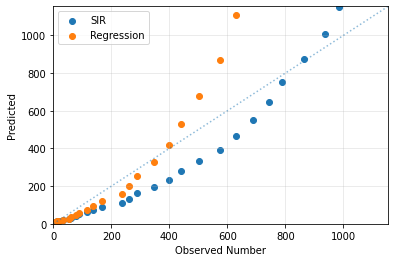

	MO


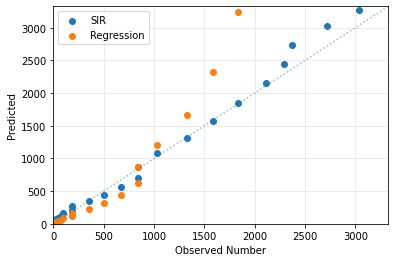

	MP


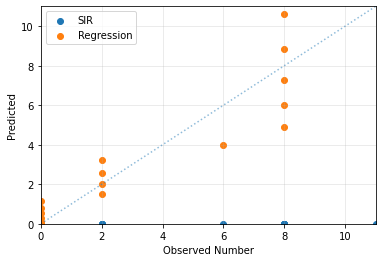

	MS


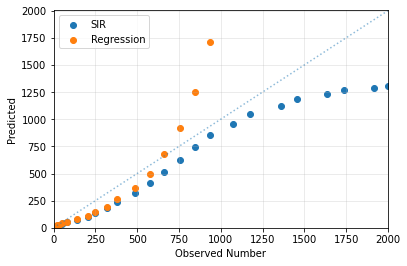

	MT


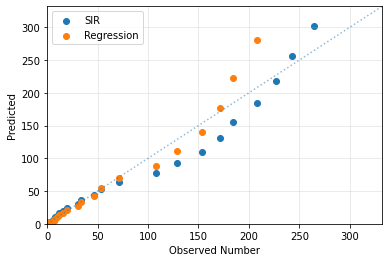

	NC


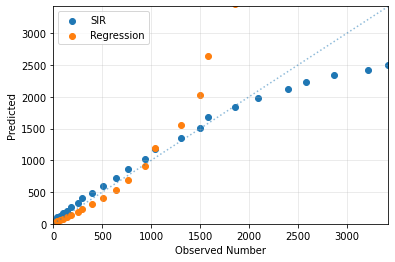

	ND


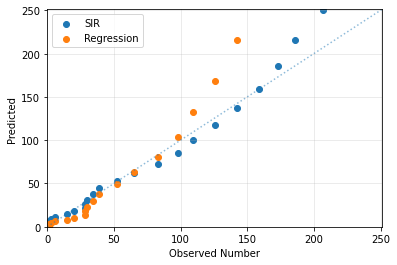

	NE


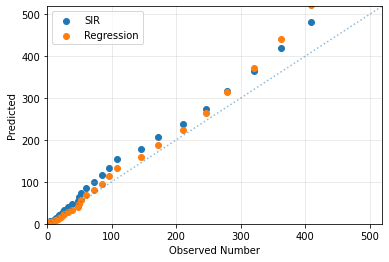

	NH


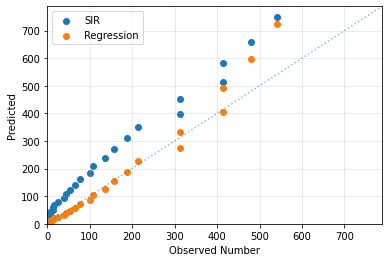

	NJ


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


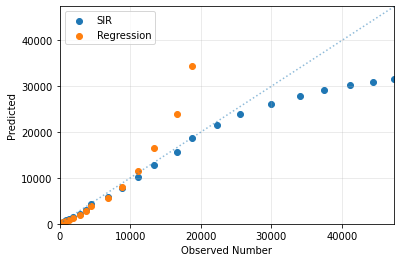

	NM


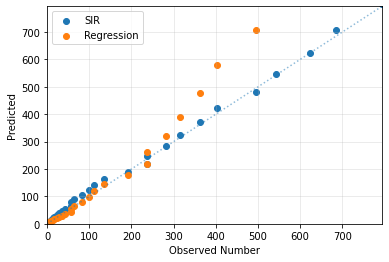

	NV


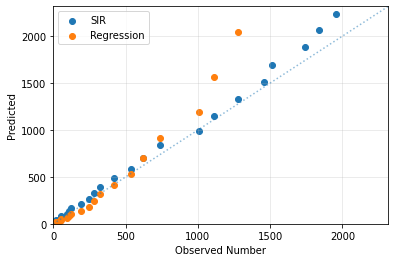

	NY


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


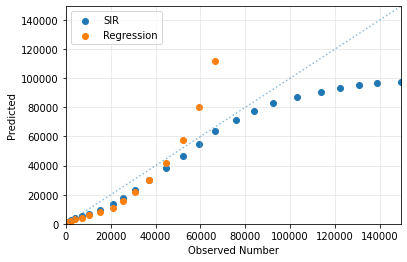

	OH


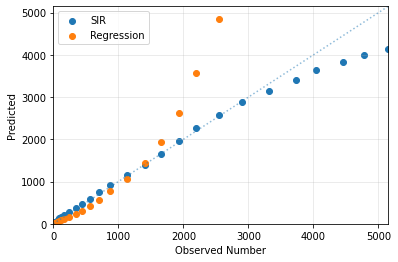

	OK


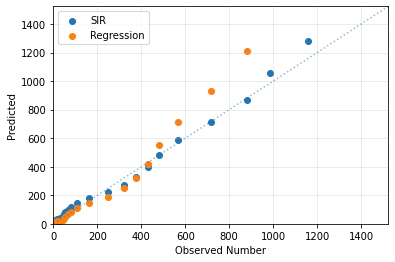

	OR


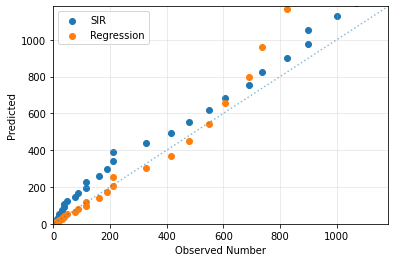

	PA


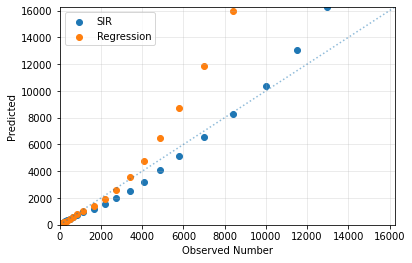

	PR


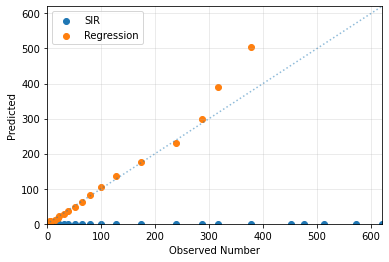

	RI


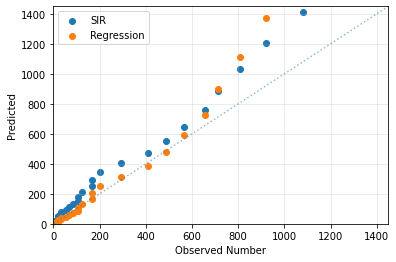

	SC


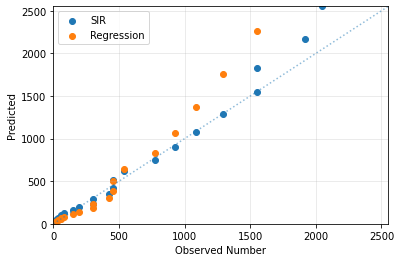

	SD


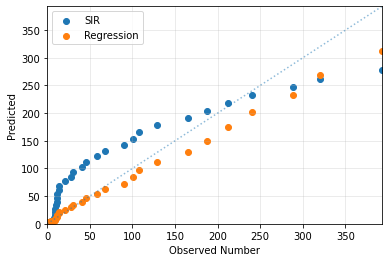

	TN


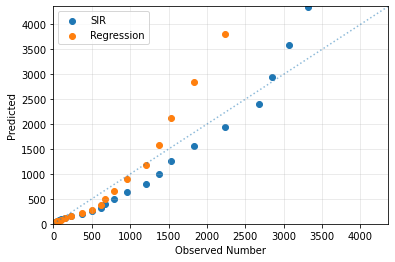

	TX


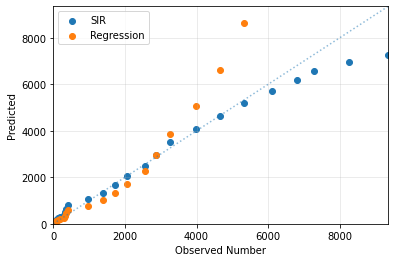

	UT


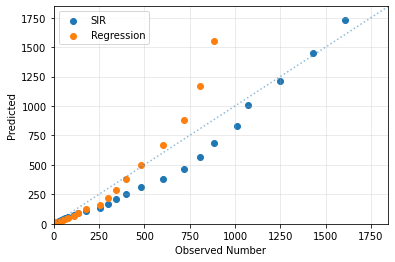

	VA


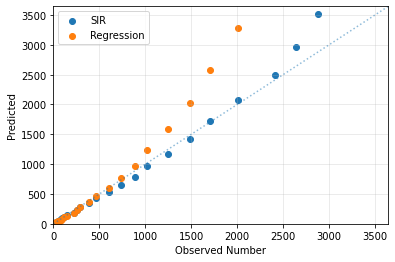

	VI


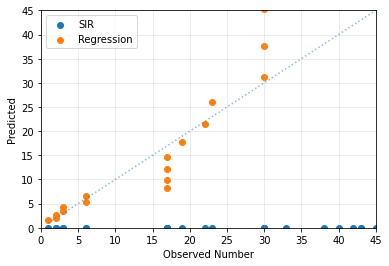

	VT


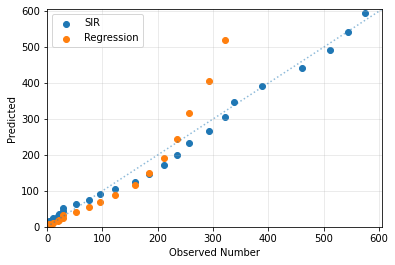

	WA


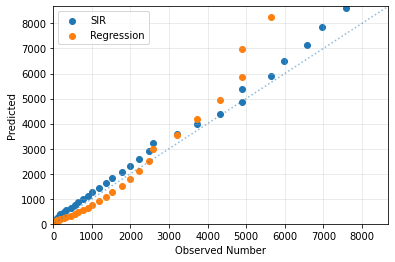

	WI


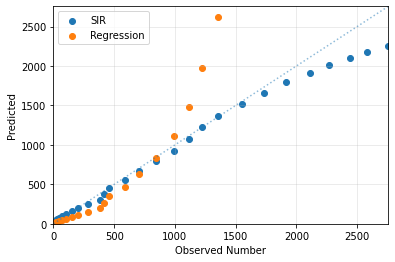

	WV


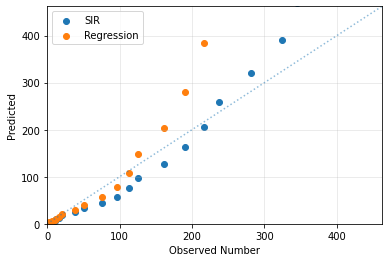

	WY


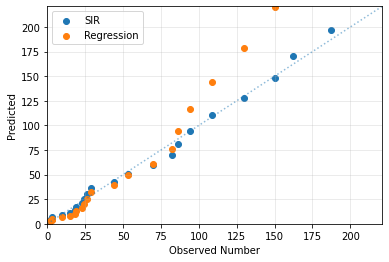

Prediction 2020-04-02 00:00:00
	AK


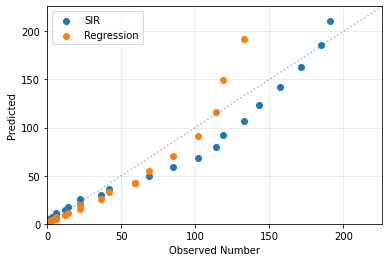

	AL


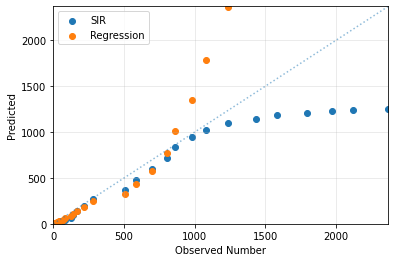

	AR


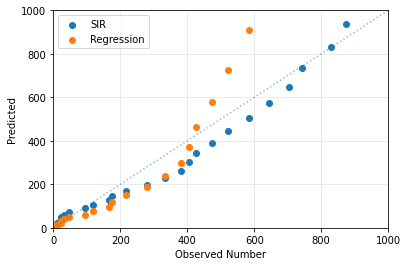

	AS


/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


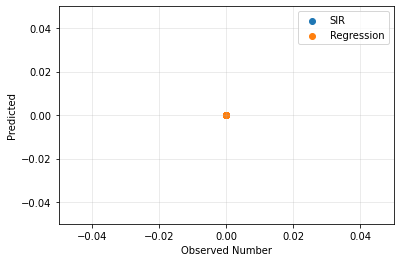

	AZ


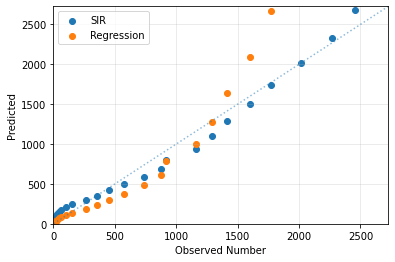

	CA


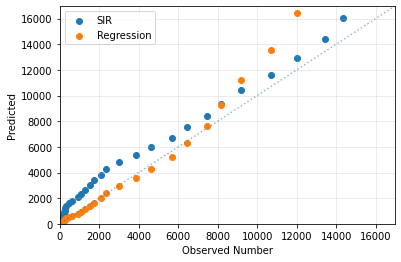

	CO


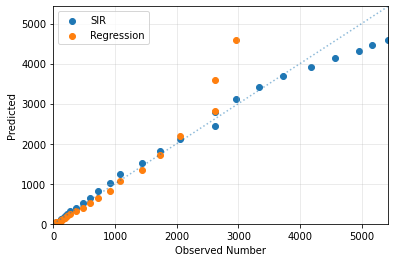

	CT


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


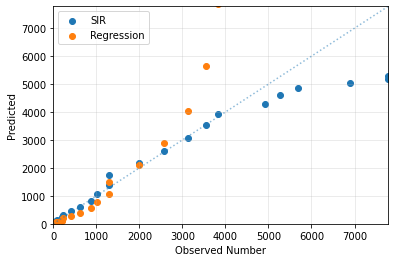

	DC


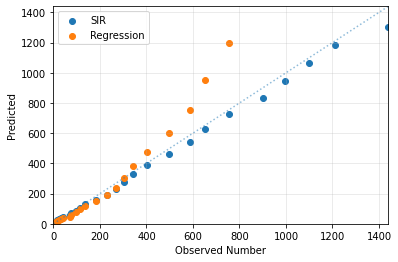

	DE


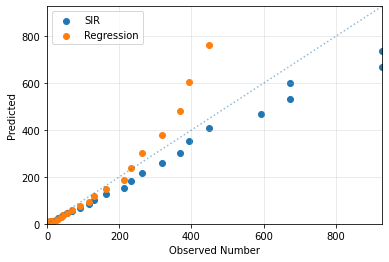

	FL


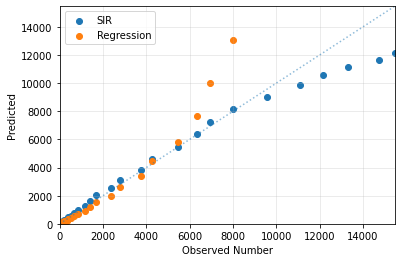

	GA


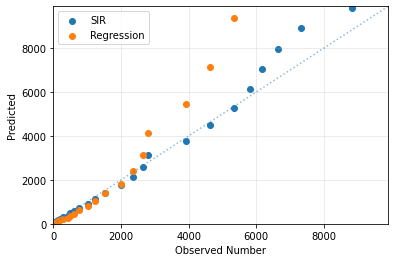

	GU


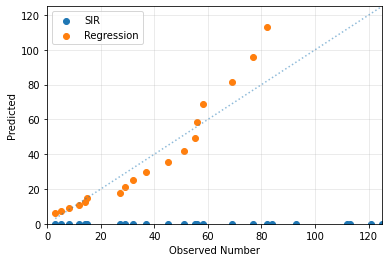

	HI


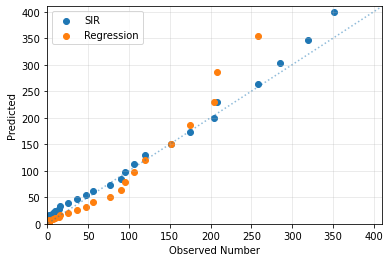

	IA


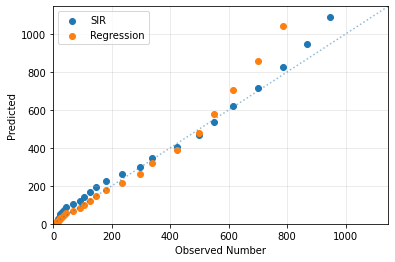

	ID


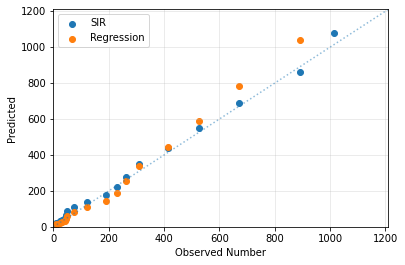

	IL


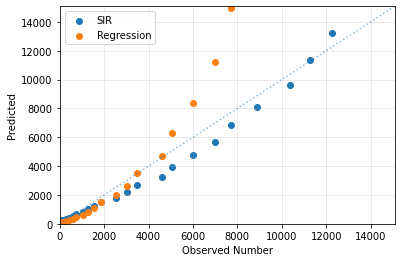

	IN


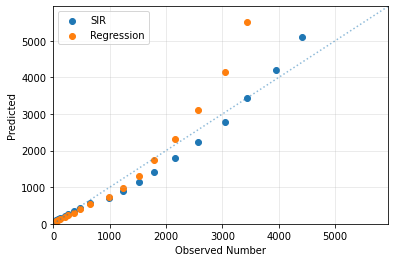

	KS


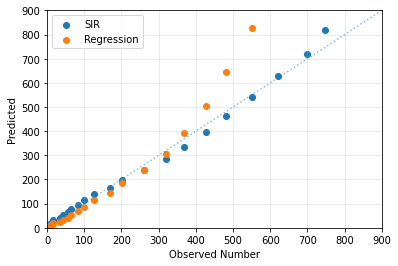

	KY


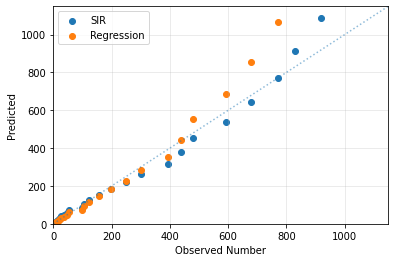

	LA


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


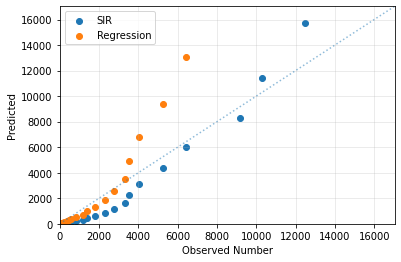

	MA


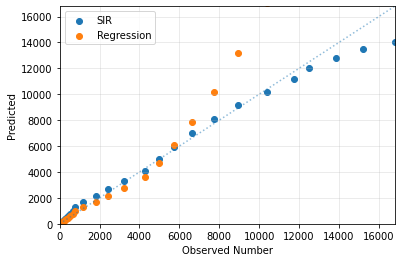

	MD


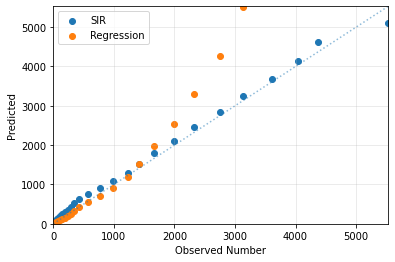

	ME


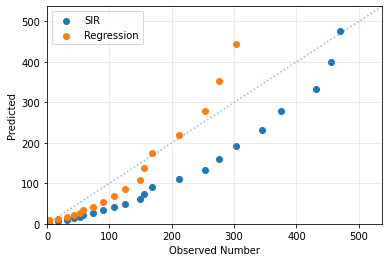

	MI


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


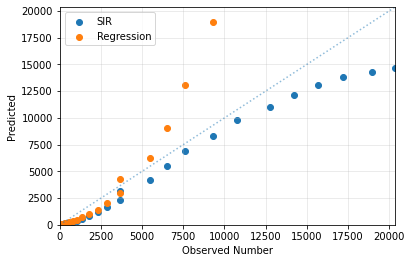

	MN


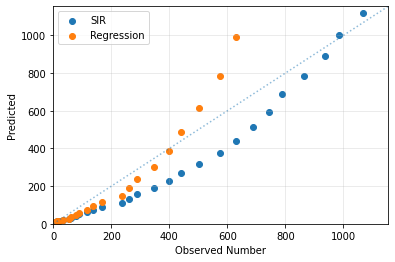

	MO


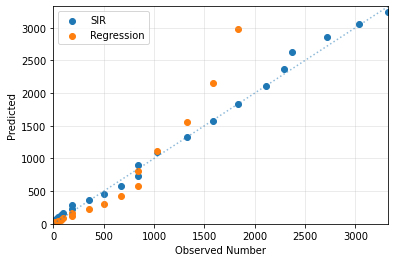

	MP


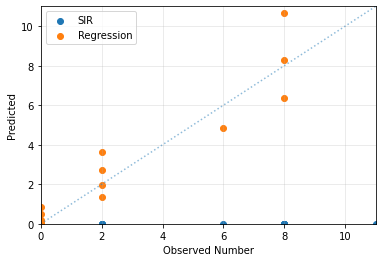

	MS


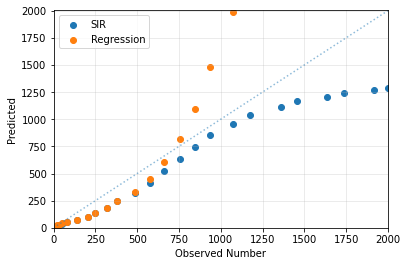

	MT


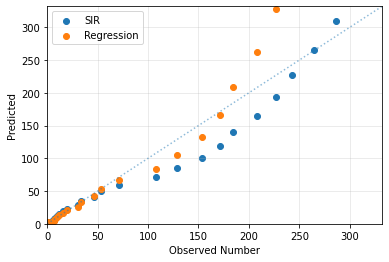

	NC


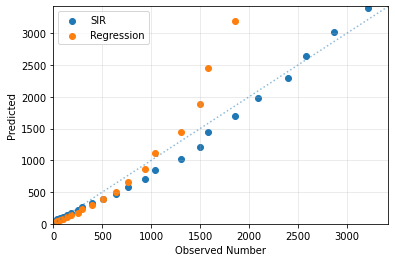

	ND


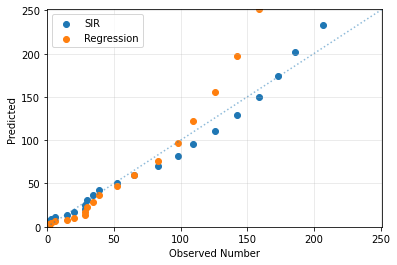

	NE


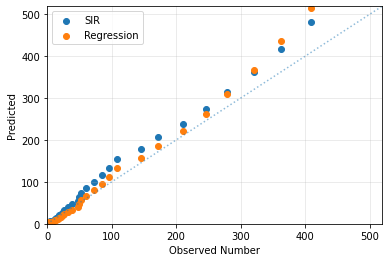

	NH


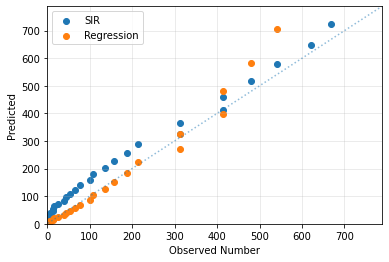

	NJ


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


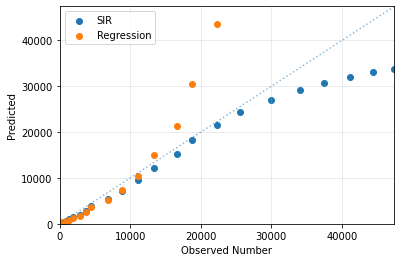

	NM


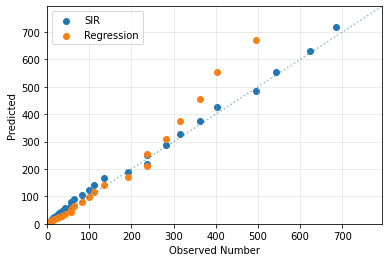

	NV


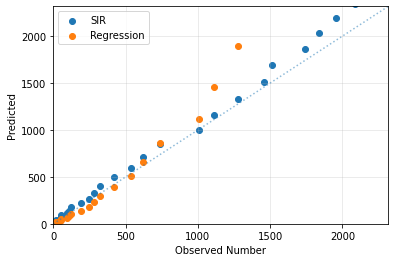

	NY


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


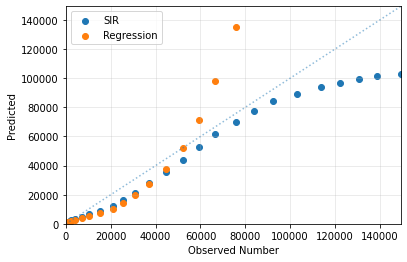

	OH


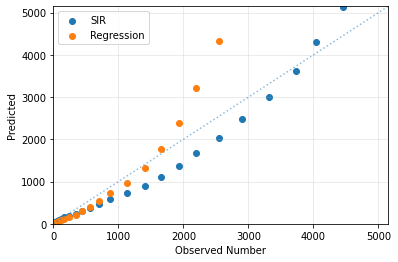

	OK


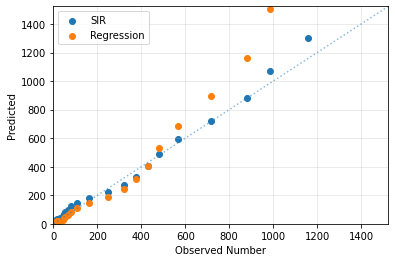

	OR


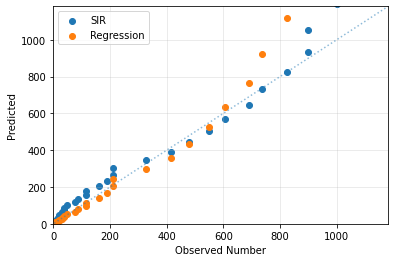

	PA


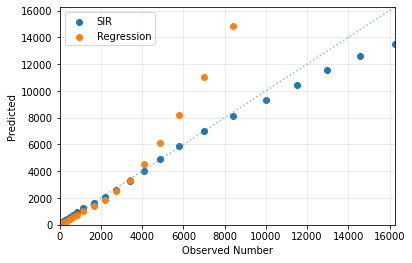

	PR


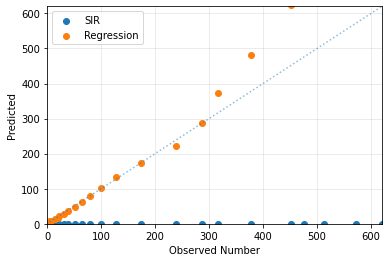

	RI


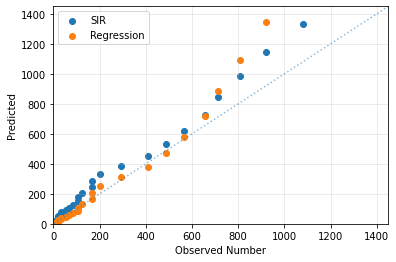

	SC


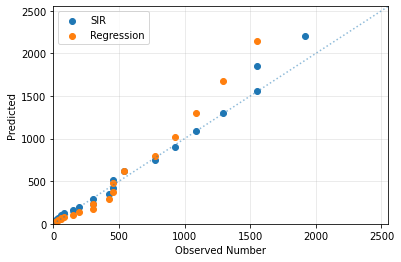

	SD


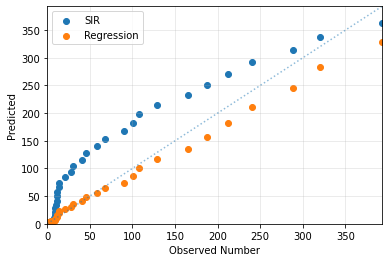

	TN


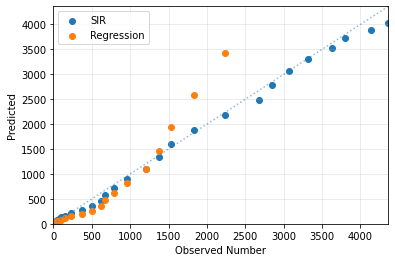

	TX


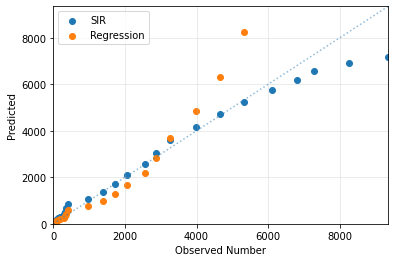

	UT


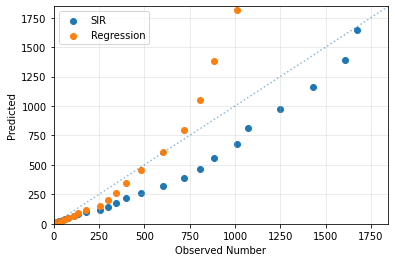

	VA


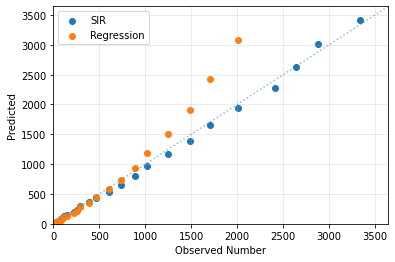

	VI


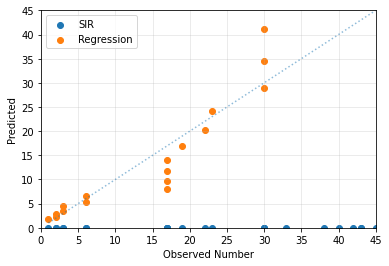

	VT


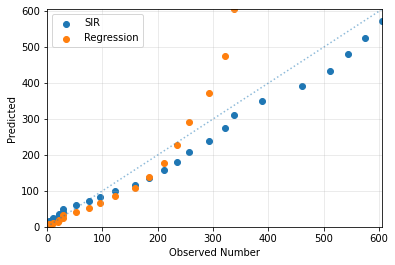

	WA


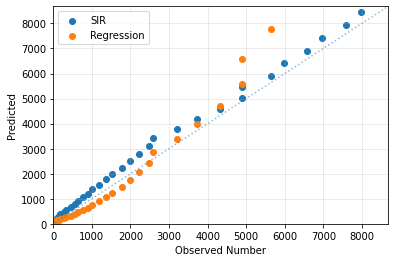

	WI


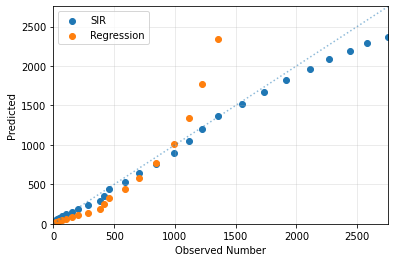

	WV


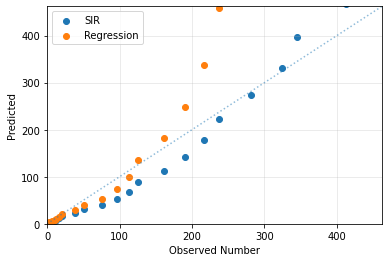

	WY


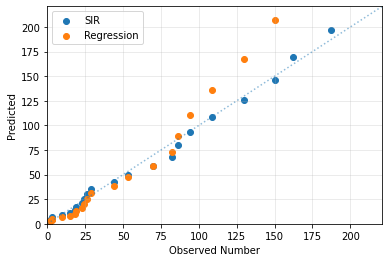

Prediction 2020-04-03 00:00:00
	AK


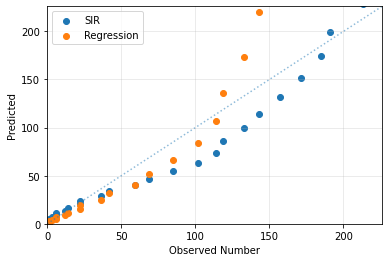

	AL


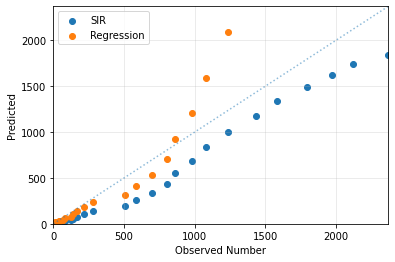

	AR


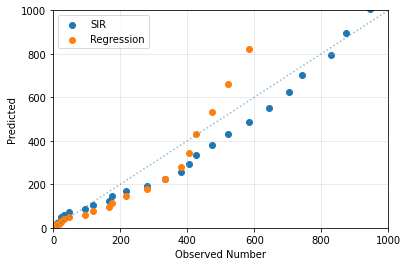

	AS


/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
/home/vincent/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


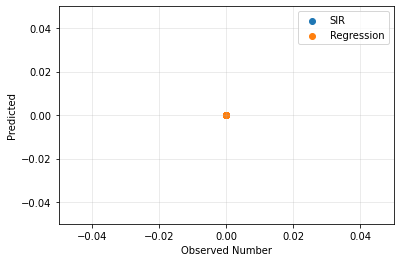

	AZ


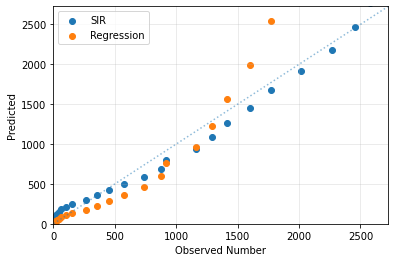

	CA


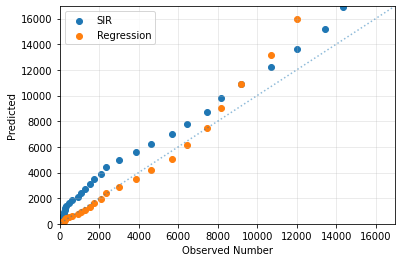

	CO


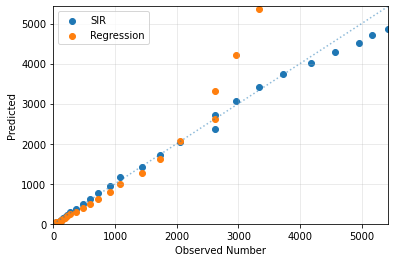

	CT


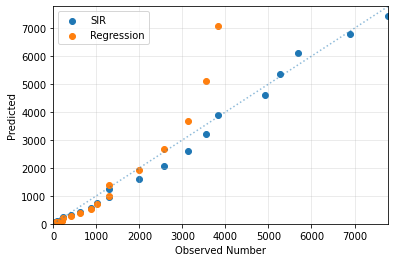

	DC


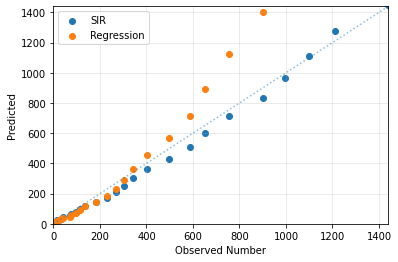

	DE


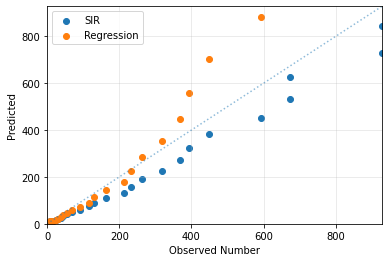

	FL


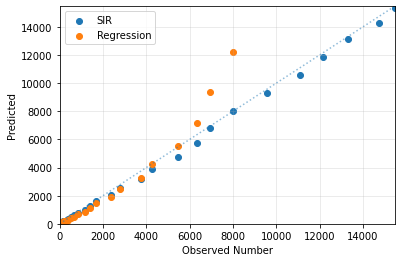

	GA


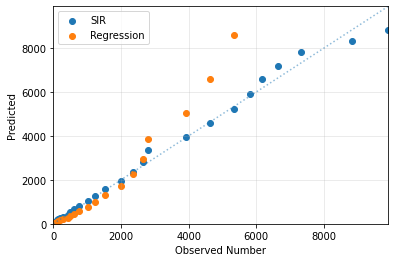

	GU


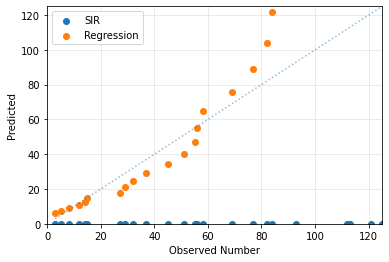

	HI


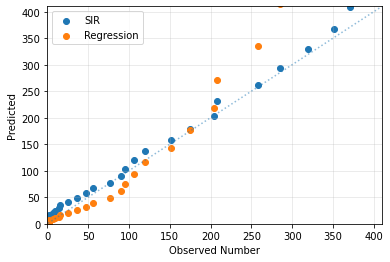

	IA


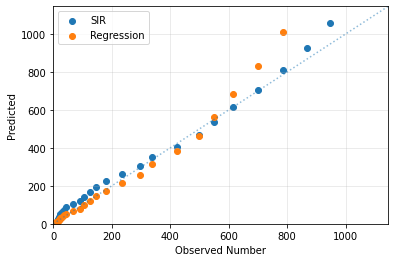

	ID


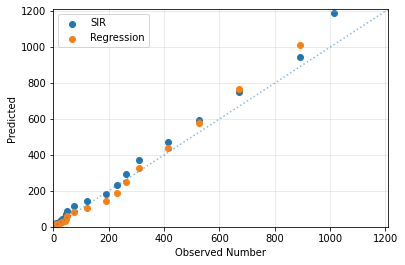

	IL


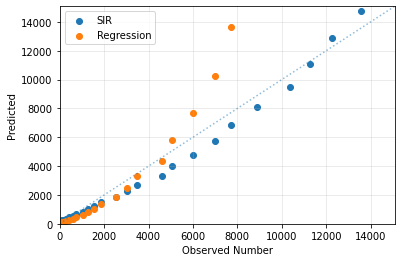

	IN


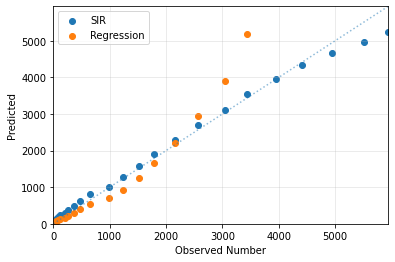

	KS


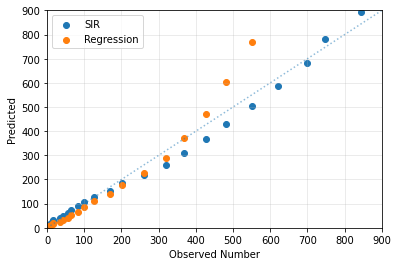

	KY


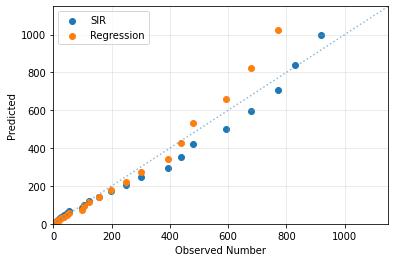

	LA


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


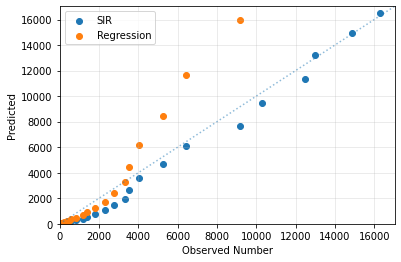

/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


	MA


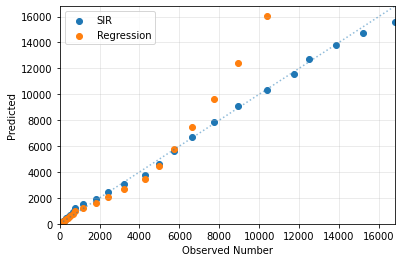

	MD


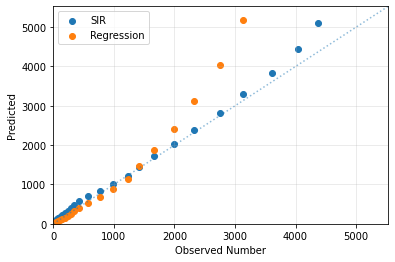

	ME


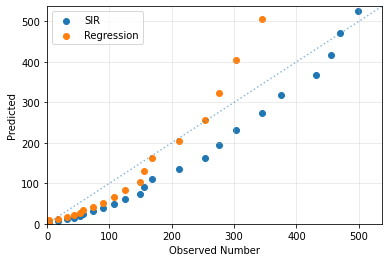

	MI


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


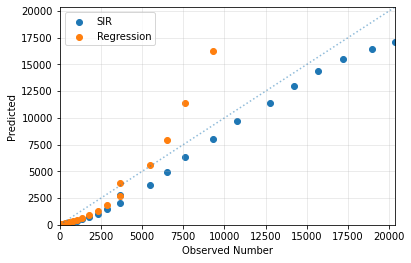

	MN


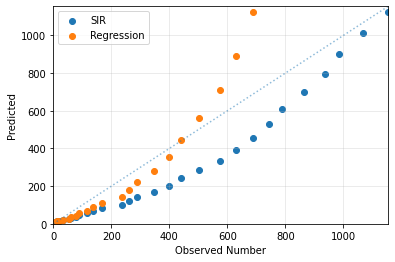

	MO


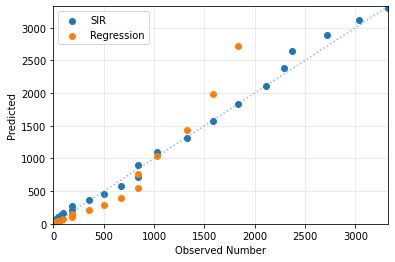

	MP


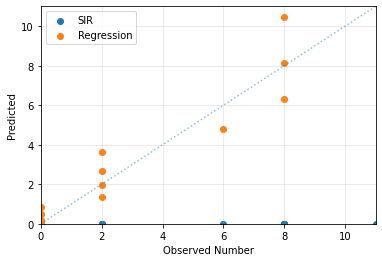

	MS


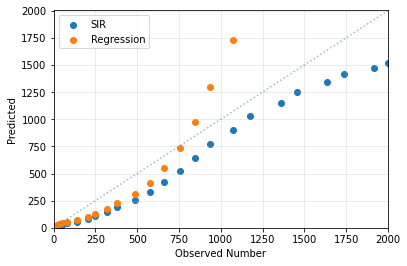

	MT


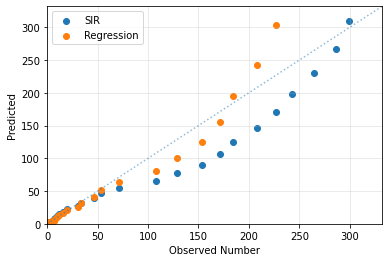

	NC


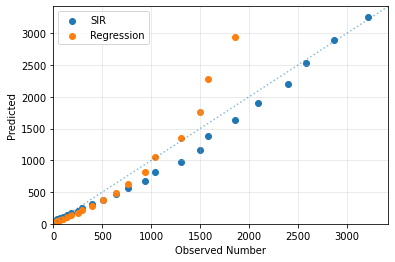

	ND


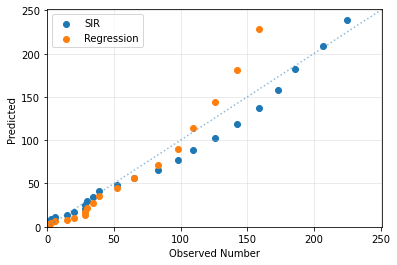

	NE


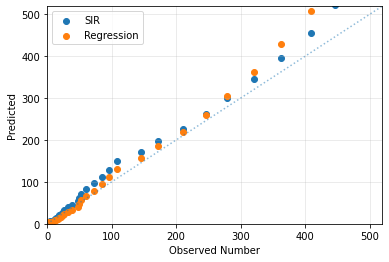

	NH


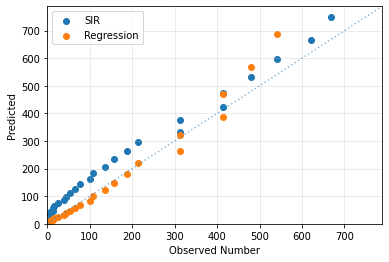

	NJ


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


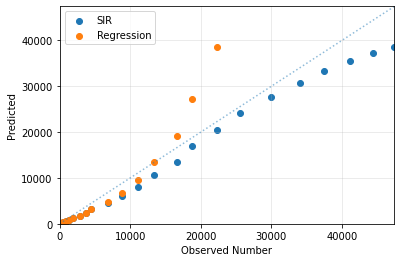

	NM


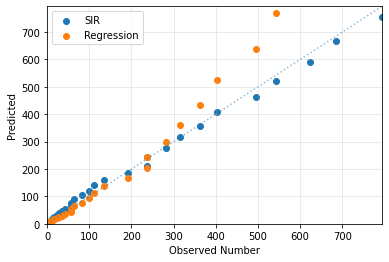

	NV


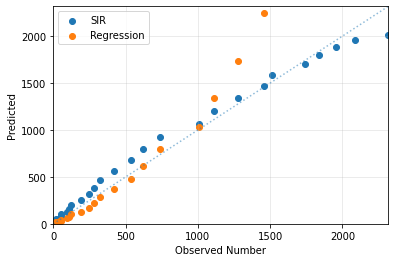

	NY


/home/vincent/miniconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


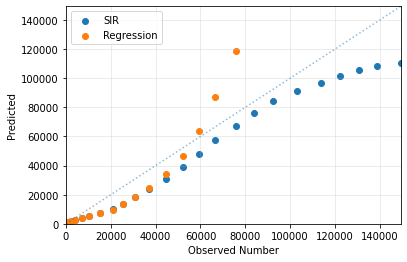

	OH


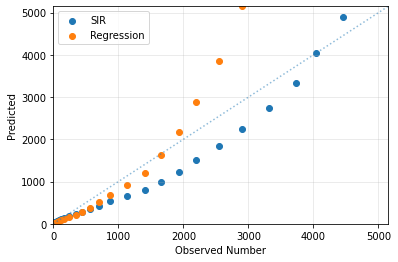

	OK


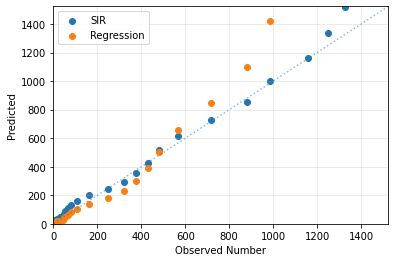

	OR


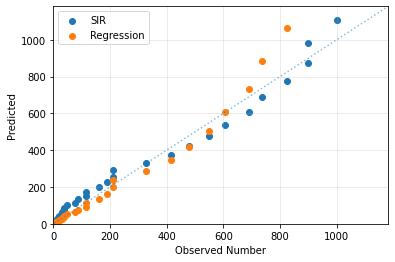

	PA


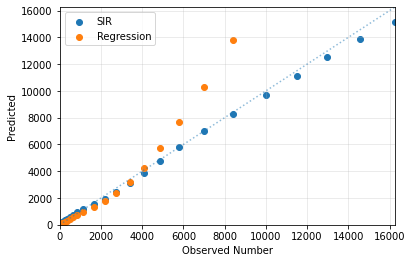

	PR


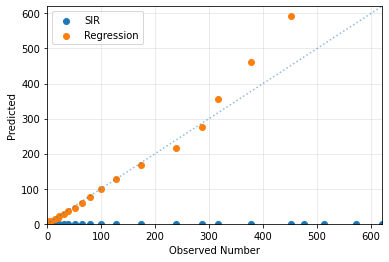

	RI


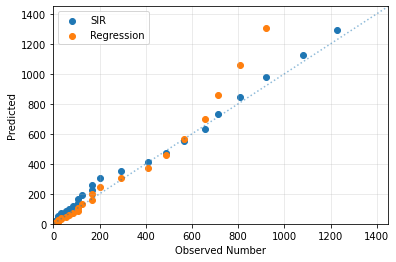

	SC


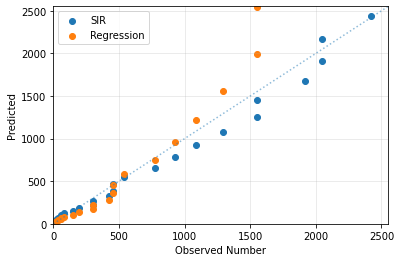

	SD


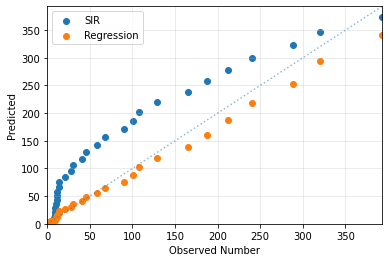

	TN


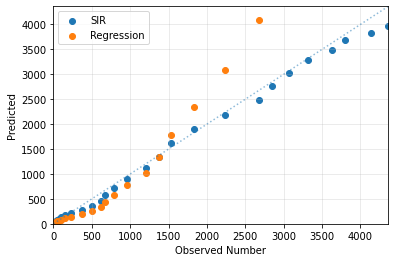

	TX


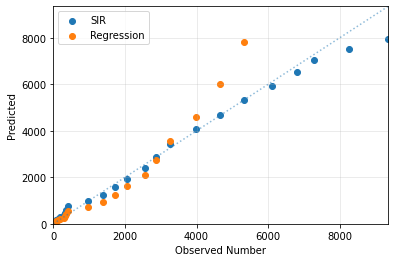

	UT


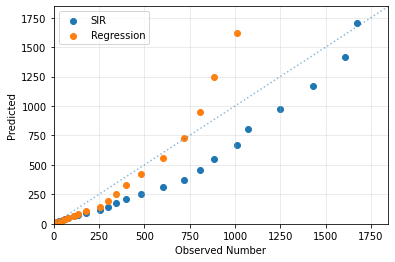

	VA


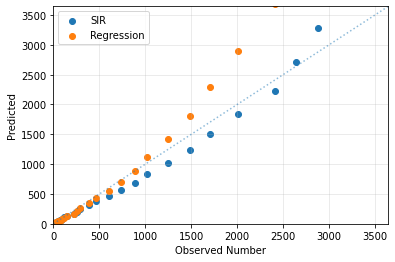

	VI


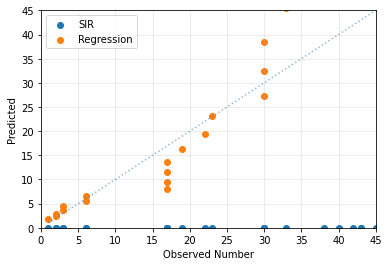

	VT


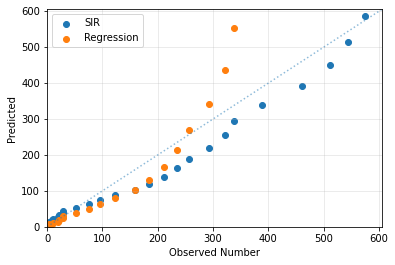

	WA


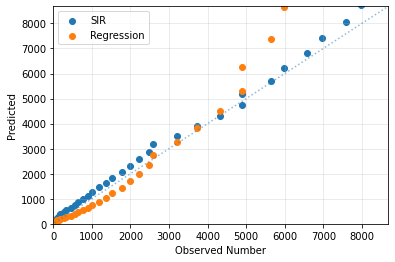

	WI


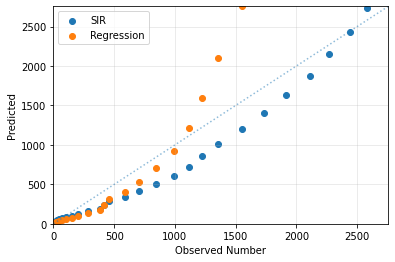

	WV


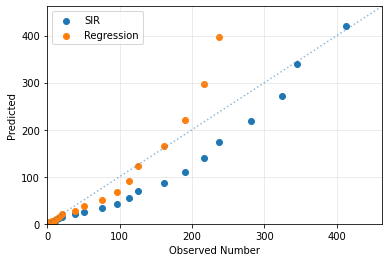

	WY


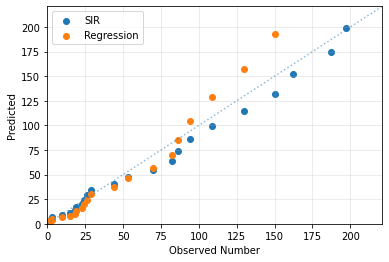

In [150]:
for pred_date in date_predictions:
    print("Prediction {}".format(pred_date))
    for state in data['state'].unique():
        print("\t{}".format(state))
        
        # Focus on state and reorder index
        state_data = data[data['state'] == state]
        state_data.index = state_data.date
        state_data = state_data.sort_index()
        
        state_data['Time'] = (state_data.index - pred_date).days
        train = state_data[state_data.index <= pred_date]

        # Focus only on non zero cases and dropna
        train = train[['Time', 'state', 'positive', 'positiveIncrease', 'death', 'deathIncrease']].fillna(0)        
        
        # Run and save models
        reg_res = regression(train, state_data)
        reg_res.to_csv('regression/{}_{:%Y%m%d}.csv'.format(state, pred_date))
        
        sir_res = sir(train, state_data)
        sir_res.to_csv('sir/{}_{:%Y%m%d}.csv'.format(state, pred_date))
        
        # Display results (train and test mixed)
        plt.figure()
        plt.scatter(state_data['positive'], sir_res['pred_case'], label = 'SIR')
        plt.scatter(state_data['positive'], reg_res['pred_case'], label = 'Regression')
        plt.plot(state_data['positive'], state_data['positive'], ls = ':', alpha = 0.5)
        
        plt.legend()
        plt.xlabel('Observed Number')
        plt.xlim(0, state_data['positive'].max())
        plt.ylabel('Predicted')
        plt.ylim(0, state_data['positive'].max())
        
        plt.grid(alpha = 0.3)
        plt.show()